In [ ]:
# basic stuff
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from google.colab import files
import os
import sklearn
import time
import json

# dim reduction and visualization
from sklearn.decomposition import PCA
# !pip install umap
# !pip install umap-learn
# import umap.umap_ as umap
from sklearn.manifold import TSNE

# torch stuff
# !pip install
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torch import nn
import torch.nn.functional as F

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Get Data

The csvs are structured as so:

* Each trial is one row (160 rows/trials for each csv)
* Each trial has a different number of timestamps - some trials take longer than others
* The number of columns is determined by the trial with the max number of timestamps in that session
* The number of columns equals: max_timestamps*(gloveinput_dim+neuraloutput_dim+cursor_dim+timestamp_dim)
* The longest trial has no null values, all other trials have null values where they have no timestamps (the shorter, the more null values)

In [ ]:
# get data from each session - 16,17,18,19
# csvs were obtained from matlab object (code in matlab)
trialdata16 = np.genfromtxt('trialdata16.csv', delimiter = ',')[1:,1:]
trialdata17 = np.genfromtxt('trialdata17.csv', delimiter = ',')[1:,1:]
trialdata18 = np.genfromtxt('trialdata18.csv', delimiter = ',')[1:,1:]
trialdata19 = np.genfromtxt('trialdata19.csv', delimiter = ',')[1:,1:]

In [ ]:
trialdata16.shape, trialdata17.shape, trialdata18.shape, trialdata19.shape

((160, 65132), (160, 62811), (160, 36582), (160, 25350))

In [ ]:
# number of timestamps for each trial; 160 trials
# timestamps obtained by copying and pasting size of timestamps - not sure how to extract from MatlabOpaque object...
timestamps_list16 = [72,47,81,52,73,46,69,116,102,52,55,60,58,49,112,42,61,37,64,58,47,53,55,46,42,40,76,35,60,52,53,49,51,51,57,48,138,35,77,70,87,46,53,857,57,37,67,37,48,43,48,368,135,44,61,40,44,45,54,46,45,47,54,69,201,67,64,40,55,65,49,44,92,62,51,37,51,46,38,41,57,46,72,65,87,56,69,50,66,39,115,70,57,71,60,40,67,115,96,123,45,40,49,40,193,154,56,67,49,48,137,53,79,59,93,43,53,43,71,74,50,39,80,69,42,39,59,237,56,50,39,42,56,45,51,41,37,52,78,25,130,71,66,47,68,71,72,56,60,63,70,58,62,116,51,101,58,60,48,47]
timestamps_list17 = [61,103,51,131,60,84,46,142,122,37,62,80,41,45,55,52,52,39,135,41,198,56,71,78,52,172,51,52,180,43,168,73,44,40,51,63,51,37,74,55,52,35,57,59,48,38,51,53,60,40,52,265,52,53,68,41,49,60,53,46,53,33,43,50,51,36,72,28,50,40,50,48,62,45,46,58,58,31,54,110,69,88,44,43,56,80,52,40,46,49,44,35,61,48,67,39,65,27,54,50,190,139,74,39,53,52,68,43,47,117,91,36,71,49,57,119,65,94,56,41,42,46,55,205,99,22,60,34,57,47,111,42,58,53,185,454,50,37,67,41,68,33,33,62,56,44,54,42,60,49,55,36,50,42,39,57,182,997,50,51]
timestamps_list18 = [113,546,140,114,68,176,24,188,104,94,114,65,123,48,113,80,98,119,105,79,70,93,73,54,68,94,93,100,108,37,85,110,67,43,140,57,104,109,97,158,59,94,51,64,78,32,91,40,62,158,46,63,71,56,86,75,68,63,106,56,43,89,53,101,126,63,67,129,63,83,81,75,71,50,36,80,115,45,71,56,46,58,39,89,35,102,86,75,27,96,49,99,106,84,62,68,115,54,76,84,66,54,101,53,80,56,49,46,62,81,41,48,42,86,43,67,95,42,82,118,86,99,36,76,66,68,31,117,47,61,39,55,48,59,93,58,52,54,51,30,185,64,72,62,85,85,93,63,66,40,54,60,35,82,58,36,42,70,59,69]
timestamps_list19 = [61,236,63,67,68,71,105,105,62,62,77,34,67,60,68,48,66,155,78,43,104,120,82,310,71,53,61,53,71,98,64,93,83,36,69,37,49,55,42,47,71,53,109,74,56,507,67,32,130,60,46,45,63,41,115,185,47,253,110,52,96,42,191,137,48,50,56,52,193,165,88,58,33,216,31,65,56,39,71,59,190,89,57,64,85,56,110,65,65,82,82,34,52,90,86,61,56,73,38,85,83,50,53,137,38,49,48,54,101,44,181,46,78,46,52,87,57,108,185,26,46,112,63,54,130,37,115,126,57,76,56,129,65,80,55,64,101,36,36,45,162,55,74,38,185,110,59,155,35,54,88,58,42,71,63,42,175,62,74,68]
# shape of glove position array, neural output array, cursor position array, timestamp array
# only dimensionality of neural output array varies with each session
shapes_list16 = [19, 54, 2, 1]
shapes_list17 = [19, 41, 2, 1]
shapes_list18 = [19, 45, 2, 1]
shapes_list19 = [19, 28, 2, 1]
neuraloutputs_shapes_list = [54,41,45,28]

In [ ]:
sessions_timestamps = [timestamps_list16, timestamps_list17, timestamps_list18, timestamps_list19]
for i, timestamps_list in enumerate(sessions_timestamps):
    print('Session {} Max trial duration: {}, Min trial duration: {}'.format(i+16, max(timestamps_list), min(timestamps_list)))

Session 16 Max trial duration: 857, Min trial duration: 25
Session 17 Max trial duration: 997, Min trial duration: 22
Session 18 Max trial duration: 546, Min trial duration: 24
Session 19 Max trial duration: 507, Min trial duration: 26


In [ ]:
# def organize_trial_data(trialdata, timestamps_list, shapes_list):
#   # The purpose of this function is to extract all of the data from the csv for each session
#   # Each trial's data - including glove, neural, timestamp, and cursor data - is stored in one row
#   # This function extracts 
#     session_organized = []
#     neural_output_shape = shapes_list[1]
#     num_timestamps = max(timestamps_list)
#     print(num_timestamps)

#     for trial in trialdata:
#         trial[np.isnan(trial)] = 0

#         gloveinput = trial[:19*num_timestamps].reshape((19, num_timestamps), order = 'F')
#         neuraloutput = trial[19*num_timestamps:(19+neural_output_shape)*num_timestamps].reshape((neural_output_shape, num_timestamps), order = 'F')
#         cursorposition = trial[(19+neural_output_shape)*num_timestamps:(19+neural_output_shape+2)*num_timestamps].reshape((2, num_timestamps), order = 'F')
#         timestamps = trial[(19+neural_output_shape+2)*num_timestamps:]

#         # trial_sorted contains all of the data for each trial
#         # trial_sorted is a list of length 160, each element represents one trial
#         # each element is a tuple of length 4, containing gloveinput, neuraloutput, cursorposition, and timestamps
#         session_organized.append([gloveinput, neuraloutput, cursorposition, timestamps])

#     return(session_organized)

def organize_trial_data(trialdata, timestamps_list, shapes_list):
  # The purpose of this function is to extract all of the data from the csv for each session
  # Each trial's data - including glove, neural, timestamp, and cursor data - is stored in one row
  # This function extracts 
    session_organized = []
    neural_output_shape = shapes_list[1]

    for trial, num_timestamps in zip(trialdata, timestamps_list):
        new_data = trial[~np.isnan(trial)]

        gloveinput = new_data[:19*num_timestamps].reshape((19, num_timestamps), order = 'F')
        neuraloutput = new_data[19*num_timestamps:(19+neural_output_shape)*num_timestamps].reshape((neural_output_shape, num_timestamps), order = 'F')
        cursorposition = new_data[(19+neural_output_shape)*num_timestamps:(19+neural_output_shape+2)*num_timestamps].reshape((2, num_timestamps), order = 'F')
        timestamps = new_data[(19+neural_output_shape+2)*num_timestamps:]

        # trial_sorted contains all of the data for each trial
        # trial_sorted is a list of length 160, each element represents one trial
        # each element is a tuple of length 4, containing gloveinput, neuraloutput, cursorposition, and timestamps
        session_organized.append([gloveinput, neuraloutput, cursorposition, timestamps])

    return(session_organized)

In [ ]:
sessions = [trialdata16, trialdata17, trialdata18, trialdata19]
sessions_timestamps = [timestamps_list16, timestamps_list17, timestamps_list18, timestamps_list19]
sessions_shapes = [shapes_list16, shapes_list17, shapes_list18, shapes_list19]
sessions_names = ['trialdata16', 'trialdata17', 'trialdata18', 'trialdata19']
sessions_organized = []

for session, timestamps_list, session_shape, name in zip(sessions, sessions_timestamps, sessions_shapes,sessions_names):
    print(name)
    sessions_organized.append(organize_trial_data(session, timestamps_list, session_shape))

trialdata16
trialdata17
trialdata18
trialdata19


In [ ]:
# 4 sessions - 16, 17, 18, 19
len(sessions_organized)

4

In [ ]:
# 160 trials per session
len(sessions_organized[0])

160

In [ ]:
# 4 elements per session - glove, neural, cursor, timestamp
len(sessions_organized[0][0])

4

In [ ]:
# the first trial's glove input (857 timestamps after padding)
sessions_organized[0][0][0].shape

(19, 72)

# Build Dataset

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, session_num, normalize_inputs = True, shuffle = False):
        if type(session_num == int):
            self.session_num = session_num
            s = session_num-16
            self.session = sessions_organized[s]
        elif type(session_num == list):
            s = [i-16 for i in session_num]
            self.session = sessions_organized[s]

        self.normalize_inputs = normalize_inputs
        self.gloveinputs = []
        self.neuraloutputs = []
        self.trialnums = []
        self.samplenums = []
        self.max_timestamps = 0
        self.input_max_val = 0

        for trialnum, trial in enumerate(self.session):
            if trial[0].shape[1] > self.max_timestamps:
                self.max_timestamps = trial[0].shape[1]
            if trial[0].max() > self.input_max_val:
                self.input_max_val = int(trial[0].max())
            self.gloveinputs.append(trial[0].T)
            self.neuraloutputs.append(trial[1].T)
            self.trialnums.append(trialnum)
            self.samplenums.append(np.arange(trial[0].shape[0]))

        def normalize_inputs(g):
            stacked = np.vstack(g)
            mean = np.mean(stacked, axis = 0)
            var = np.var(stacked, axis = 0)

            normalized_inputs = []
            for trial in self.gloveinputs:
                normalized = (trial-mean)/var
                normalized_inputs.append(normalized)

            return(normalized_inputs)

        def shuffle_data(g, n, t, sn):
            assert len(g) == len(n)
            assert len(g) == len(t)
            assert len(g) == len(sn)
            p = np.random.permutation(len(g))
            return(g[p], n[p], t[p], sn[p])

        self.gloveinputs_normalized = normalize_inputs(self.gloveinputs)

        if shuffle == True:
            self.gloveinputs, self.neuraloutputs, self.trialnums, self.samplenums = \
                shuffle_data(self.gloveinputs, self.neuraloutputs, self.trialnums, self.samplenums)
            

    def __len__(self):
        assert len(self.gloveinputs) == len(self.neuraloutputs)
        return len(self.gloveinputs)

    def __getitem__(self, idx):
        if self.normalize_inputs == True:
            gloveinput = torch.from_numpy(self.gloveinputs_normalized[idx])
        else:
            gloveinput = torch.from_numpy(self.gloveinputs[idx])
        neuraloutput = torch.from_numpy(self.neuraloutputs[idx])
        samplenum = self.samplenums[idx]
        trialnum = self.trialnums[idx]

        return gloveinput.float().t(), neuraloutput.float(), samplenum, trialnum, self.session_num

In [ ]:
np.random.seed(1)

session16_dataset = CustomDataset(session_num = 16, normalize_inputs = True)#, shuffle = True)
session17_dataset = CustomDataset(session_num = 17, normalize_inputs = True)#, shuffle = True)
session18_dataset = CustomDataset(session_num = 18, normalize_inputs = True)#, shuffle = True)
session19_dataset = CustomDataset(session_num = 19, normalize_inputs = True)#, shuffle = True)

sessions_dataset_list = [session16_dataset, session17_dataset, session18_dataset, session19_dataset]

In [ ]:
session16_dataset[0][0].shape

torch.Size([19, 72])

In [ ]:
torch.manual_seed(1)

train_dataset_list = []
test_dataset_list = []
toy_dataset_list = []

train_loaders_list = []
test_loaders_list = []
toy_loaders_list = []


# 60/20/20 split for each session
for i, session_dataset in enumerate(sessions_dataset_list):
    num_instances = len(session_dataset)
    train_split = int(num_instances*.8)

    train_dataset = Subset(session_dataset, np.arange(num_instances)[:train_split])
    test_dataset = Subset(session_dataset, np.arange(num_instances)[train_split:])
    # this is used to make sure the network can achieve zero loss on a single instance
    toy_dataset = Subset(session_dataset, np.arange(num_instances)[:1])

    train_dataset_list.append(train_dataset)
    test_dataset_list.append(test_dataset)
    toy_dataset_list.append(toy_dataset)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, pin_memory=True, sampler=None)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, pin_memory=True)
    # this is used to make sure the network can achieve zero loss on a single instance
    toy_loader = torch.utils.data.DataLoader(toy_dataset, batch_size=1, pin_memory=True)

    train_loaders_list.append(train_loader)
    test_loaders_list.append(test_loader)
    toy_loaders_list.append(toy_loader)

    print('Session number: {}'.format(i+16))
    print('Total dataset size: {}'.format(len(session_dataset)))
    print('Number of train instances: {}, Number of test instances: {}'\
          .format(len(train_dataset), len(test_dataset)))

    print('\n')

Session number: 16
Total dataset size: 160
Number of train instances: 128, Number of test instances: 32


Session number: 17
Total dataset size: 160
Number of train instances: 128, Number of test instances: 32


Session number: 18
Total dataset size: 160
Number of train instances: 128, Number of test instances: 32


Session number: 19
Total dataset size: 160
Number of train instances: 128, Number of test instances: 32




# Build Model

In [ ]:
class TempConvNet(torch.nn.Module):
    def __init__(self, input_dim, output_dim, num_conv_layers, kernel_size, padding):
        super(TempConvNet, self).__init__()
        self.net = nn.ModuleList()
        assert num_conv_layers >= 1
        self.num_conv_layers = num_conv_layers
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.kernel_size = kernel_size
        self.padding = padding
        
        # 1D convolutional layers
        for i in range(num_conv_layers):
            self.net.append(nn.Conv1d(in_channels = input_dim, out_channels = input_dim*2, \
                                      kernel_size = kernel_size, padding = padding))
            self.net.append(nn.ReLU())
            input_dim *= 2

        # output layer
        self.net.append(nn.Linear(input_dim, output_dim))
    
    def forward(self, x):
        for layer in self.net:
            if type(layer)==torch.nn.modules.linear.Linear: 
                x = layer(x.t())
            else:
                x = layer(x)
        return(x)

In [ ]:
def train(loader, model, optimizer, criterion):
    model.train()
    batch_losses = []
    # gloveinput, neuraloutput, samplenum, trialnum, self.session_num
    for i, (input, target, samplenum, trialnum, session_num) in enumerate(loader):
        input = input.to(device, dtype=torch.float)
        target = target.to(device, dtype=torch.float)
        
        pred = model(input)
        loss = criterion(pred, target)  # calculate loss
        mean_batch_loss = loss.item()
        batch_losses.append(mean_batch_loss)

        optimizer.zero_grad()
        loss.backward()  # one backward pass
        optimizer.step()  # update the parameters

    avg_loss_epoch = sum(batch_losses)/len(batch_losses)
    return(avg_loss_epoch)

def test(loader, model, optimizer, criterion):
    model.eval()
    batch_losses = []

    with torch.no_grad():
        for i, (input, target, samplenum, trialnum, session_num) in enumerate(loader):
            input = input.to(device, dtype=torch.float)
            target = target.to(device, dtype=torch.float)
            pred = model(input)

            loss = criterion(pred, target)  
            mean_batch_loss = loss.item()
            batch_losses.append(mean_batch_loss)

    avg_loss_epoch = sum(batch_losses)/len(batch_losses)
    return(avg_loss_epoch)

def get_instance_losses(loader, model, criterion = torch.nn.MSELoss(reduction='none')):
    model.eval()
    inputs = []
    targets = []
    preds = []
    trialnums = []
    samplenums = []
    losses = []

    with torch.no_grad():
        for i, (input, target, samplenum, trialnum, session_num) in enumerate(loader):
            input = input.to(device, dtype=torch.float)
            target = target.to(device, dtype=torch.float)

            pred = model(input)
            all_losses_batch = criterion(pred, target)  # calculate loss
            all_losses_batch = all_losses_batch.detach().cpu().data.numpy()
            
            inputs.append(input.cpu().data.numpy().T)
            targets.append(target.cpu().data.numpy())
            preds.append(pred)
            samplenums.append(samplenum)
            trialnums.append(trialnum)
            losses.append(all_losses_batch)

    all_inputs = np.vstack(inputs)
    all_targets = np.vstack(targets)
    all_preds = np.vstack(preds)
    all_samplenums = np.hstack(samplenums)
    all_trialnums = np.hstack(trialnums)

    all_losses = np.vstack(losses)
    all_losses = np.mean(all_losses, axis = 1)

    all_data = [all_losses, all_inputs, all_targets, all_preds, all_samplenums, all_trialnums, session_num]
    return(all_data)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import itertools
all_dataset_permutations = list(itertools.permutations([0, 1, 2, 3]))

# Train and Test Models

In [ ]:
# for every learning rate factor
#     for every permutation
#         initialize a model
#         for every dataset in the permuatation
#             train the model on that dataset
#             save the model weights and instance data
#             update the learning rate for convolutional layers by factor of "learning rate factor"
#             randomly initialize linear layer

In [ ]:
lr = 0.01
lr_factors = [0.7,0.3,0.1]
dataset_permutations = [[0,1,2,3],[1,0,3,2],[2,3,0,1],[3,2,1,0]]

# get randomly initialized linear layers
linear_layers = []
for output_shape in neuraloutputs_shapes_list:
    m = TempConvNet(input_dim = 19, output_dim=output_shape, num_conv_layers = 2, kernel_size = 5, padding = 2).to(device)
    linear_layers.append(m.net[-1])

r2_factor_train = []
r2_factor_test = []
for lr_factor in lr_factors:

    r2_perm_train = []
    r2_perm_test = []
    for perm in dataset_permutations:

        output_shape = neuraloutputs_shapes_list[perm[0]]
        lr = 0.01
        model = TempConvNet(input_dim = 19, output_dim=output_shape, num_conv_layers = 2, kernel_size = 5, padding = 2).to(device)

        r2_session_train = []
        r2_session_test = []
        for i, j in enumerate(perm):
            #randomly initialize linear layer
            model.net[-1] = linear_layers[j]

            train_dataset, test_dataset, output_shape = \
                train_dataset_list[j], test_dataset_list[j], neuraloutputs_shapes_list[j]

            criterion = torch.nn.MSELoss()
            optimizer = torch.optim.Adam([
                {'params': model.net[0].parameters(), 'lr': lr},
                {'params': model.net[-3].parameters(), 'lr': lr},
                {'params': model.net[-1].parameters(), 'lr': 0.01}])
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.7, patience=5, min_lr=0.00001)   
            total_params = sum(p.numel() for p in model.parameters())

            print('Session Number: {}'.format(j+16))
            print('Num Conv Layers: {}, Total Parameters: {}'\
                .format(model.num_conv_layers, total_params))

            train_losses = []
            val_losses = []
            test_losses = []

            start = time.time()
            for epoch in range(501):
                lr = scheduler.optimizer.param_groups[0]['lr']
                train_loss = train(train_dataset, model, optimizer, criterion)
                test_loss = test(test_dataset, model, optimizer, criterion)
                scheduler.step(test_loss)
                if epoch % 50==0:
                    print('Epoch: {:03d}, LR: {:7f}, Train Loss: {:.7f}, Test Loss: {:.7f}'\
                          .format(epoch, lr, train_loss, test_loss))

                train_losses.append(train_loss)
                test_losses.append(test_loss)
            end = time.time()

            print('Time to train model: {}'.format(end-start))
            plt.plot(train_losses)
            plt.plot(test_losses)
            plt.title('Losses - Session: {}, Permutation Number: {}, Num Conv Layers: {}'.format(j+16, i, model.num_conv_layers))
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend(['Train Losses', 'Test Losses'])
            plt.show()

            # update learning rate by factor of lr_factor
            lr = 0.01*(lr_factor**(i+1))

            train_instance_data = get_instance_losses(train_dataset, model)
            test_instance_data = get_instance_losses(test_dataset, model)
            instance_data = [train_instance_data, test_instance_data]

            r2_train = sklearn.metrics.r2_score(train_instance_data[2],train_instance_data[3],multioutput='variance_weighted')
            r2_test = sklearn.metrics.r2_score(test_instance_data[2],test_instance_data[3],multioutput='variance_weighted')

            r2_session_train.append(r2_train)
            r2_session_test.append(r2_test)

            # save model
            parent_directory = '/content/drive/My Drive/Miller_Lab/FIU/Temporal_CNN/TransferLearningPart2/'
            lr_fol = str(lr_factor)+'learningrate/'
            string_ints = [str(num+16) for num in perm]
            str_of_ints = '-'.join(string_ints)+'/'
            dataset_num = 'Session'+str(j+16)+'/'
            model_save_dir = parent_directory+lr_fol+str_of_ints+dataset_num+'model_weights.pth'
            print(model_save_dir)
            torch.save(model.state_dict(), model_save_dir)
        
        r2_perm_train.append(r2_session_train)
        r2_perm_test.append(r2_session_test)

    r2_factor_train.append(r2_perm_train)
    r2_factor_test.append(r2_perm_test)

parent_directory = '/content/drive/My Drive/Miller_Lab/FIU/Temporal_CNN/TransferLearningPart2/'
with open(parent_directory+'train_r2', 'w') as f:
    json.dump(r2_factor_train, f, indent=2)
with open(parent_directory+'test_r2', 'w') as f:
    json.dump(r2_factor_test, f, indent=2) 

Session Number: 16
Num Conv Layers: 2, Total Parameters: 22322
Epoch: 000, LR: 0.010000, Train Loss: 25.2101135, Test Loss: 4.8063261


KeyboardInterrupt: ignored

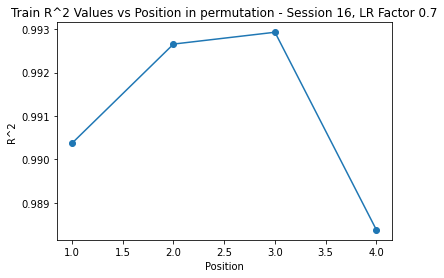

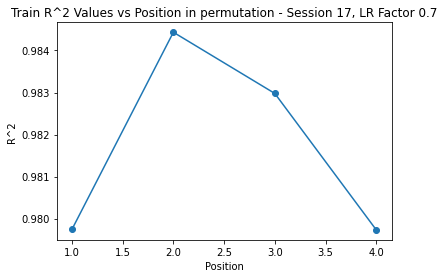

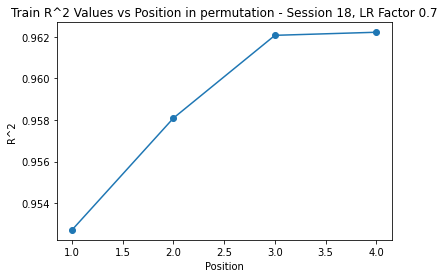

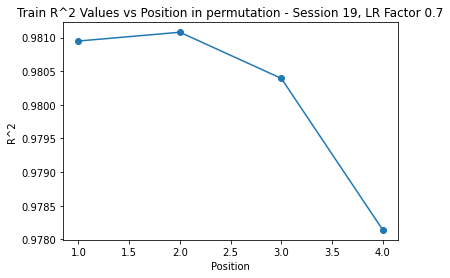

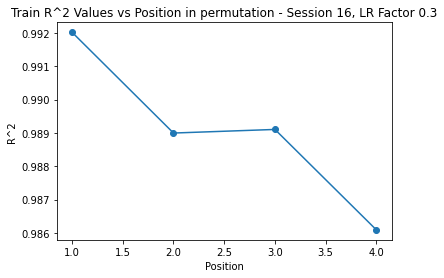

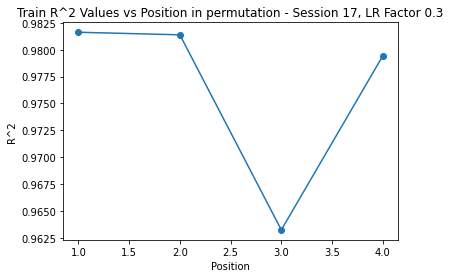

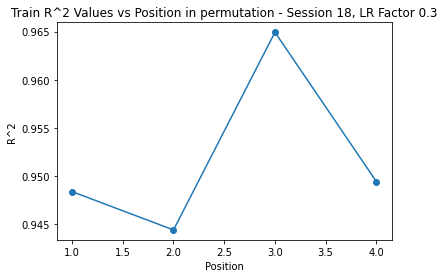

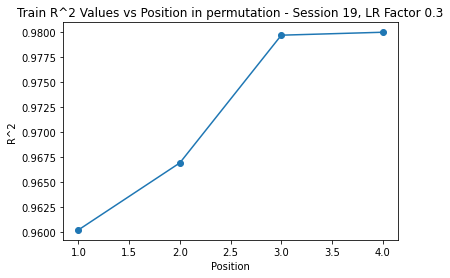

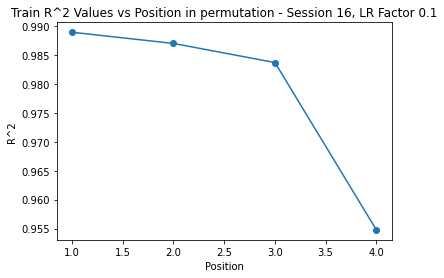

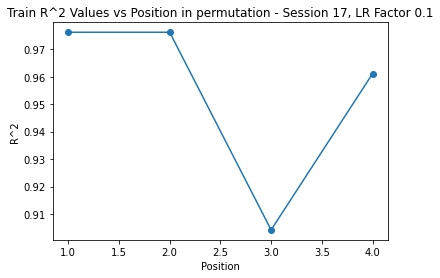

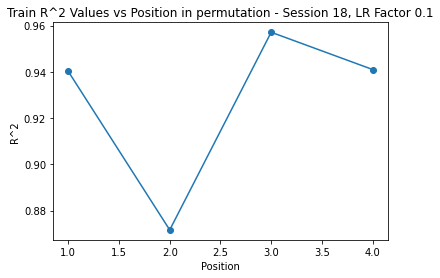

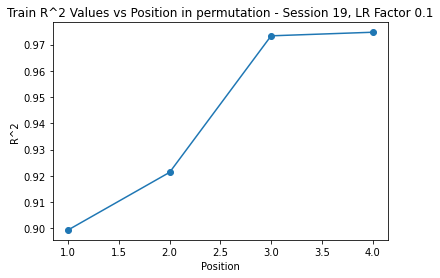

In [ ]:
for lrf, lst1 in zip(lr_factors, r2_factor_train):
    x = [1,2,3,4]
    r2_16_1 = lst1[0][0]
    r2_16_2 = lst1[1][1]
    r2_16_3 = lst1[2][2]
    r2_16_4 = lst1[3][3]
    plt_16 = [r2_16_1,r2_16_2,r2_16_3,r2_16_4]
    plt.plot(x,plt_16)
    plt.scatter(x,plt_16)
    plt.title('Train R^2 Values vs Position in permutation - Session 16, LR Factor {}'.format(lrf))
    plt.xlabel('Position')
    plt.ylabel('R^2')
    plt.show()

    r2_17_1 = lst1[0][1]
    r2_17_2 = lst1[1][0]
    r2_17_3 = lst1[2][3]
    r2_17_4 = lst1[3][2]
    plt_17 = [r2_17_1,r2_17_2,r2_17_3,r2_17_4]
    plt.plot(x,plt_17)
    plt.scatter(x,plt_17)
    plt.title('Train R^2 Values vs Position in permutation - Session 17, LR Factor {}'.format(lrf))
    plt.xlabel('Position')
    plt.ylabel('R^2')
    plt.show()

    r2_18_1 = lst1[0][2]
    r2_18_2 = lst1[1][3]
    r2_18_3 = lst1[2][0]
    r2_18_4 = lst1[3][1]
    plt_18 = [r2_18_1,r2_18_2,r2_18_3,r2_18_4]
    plt.plot(x,plt_18)
    plt.scatter(x,plt_18)
    plt.title('Train R^2 Values vs Position in permutation - Session 18, LR Factor {}'.format(lrf))
    plt.xlabel('Position')
    plt.ylabel('R^2')
    plt.show()

    r2_19_1 = lst1[0][3]
    r2_19_2 = lst1[1][2]
    r2_19_3 = lst1[2][1]
    r2_19_4 = lst1[3][0]
    plt_19 = [r2_19_1,r2_19_2,r2_19_3,r2_19_4]
    plt.plot(x,plt_19)
    plt.scatter(x,plt_19)
    plt.title('Train R^2 Values vs Position in permutation - Session 19, LR Factor {}'.format(lrf))
    plt.xlabel('Position')
    plt.ylabel('R^2')
    plt.show()

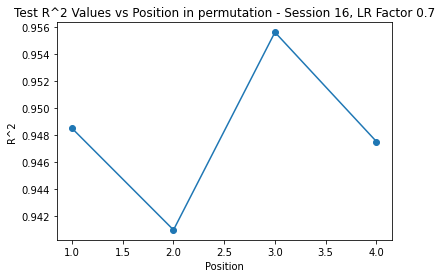

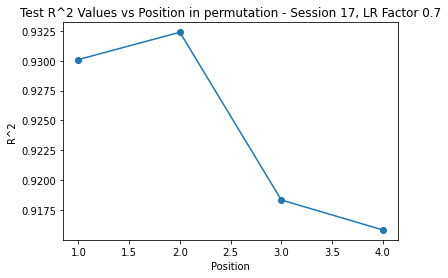

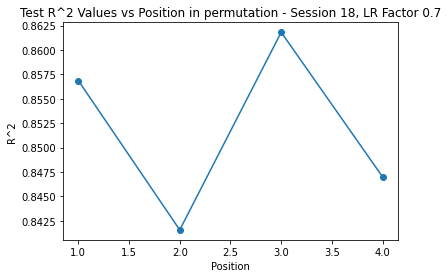

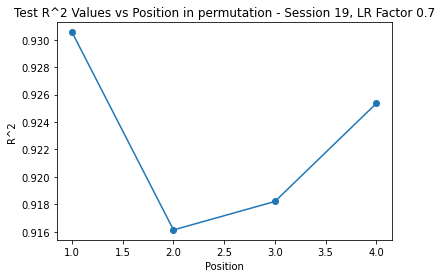

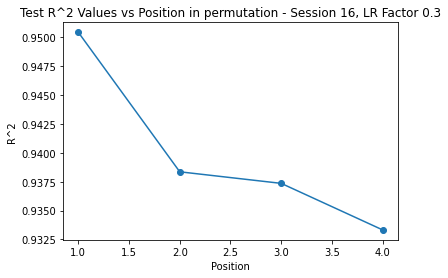

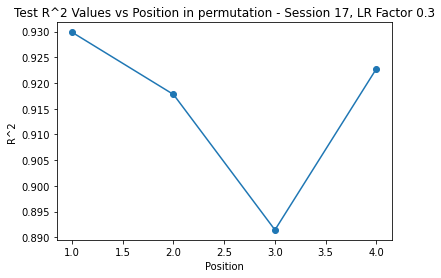

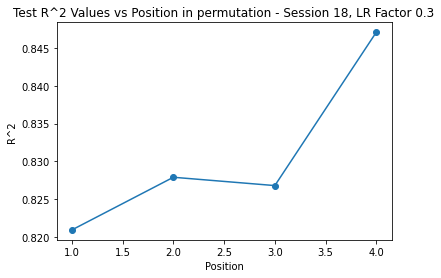

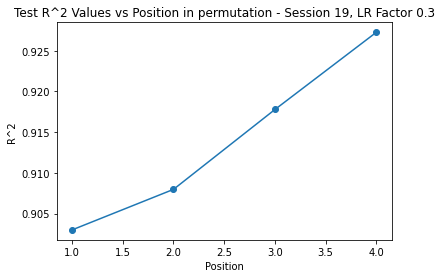

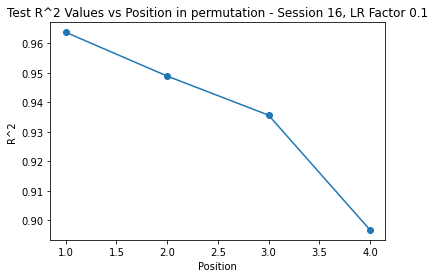

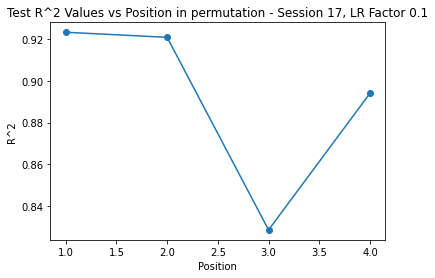

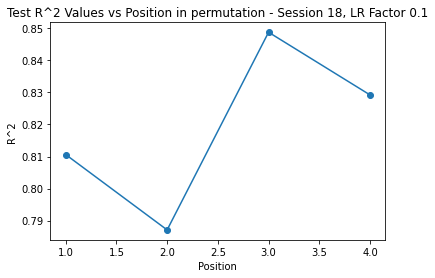

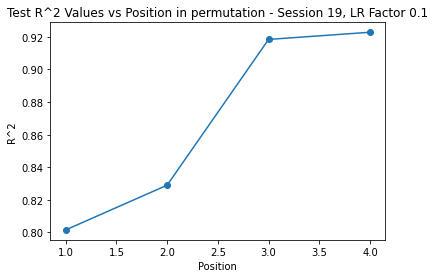

In [ ]:
for lrf, lst1 in zip(lr_factors, r2_factor_test):
    x = [1,2,3,4]
    r2_16_1 = lst1[0][0]
    r2_16_2 = lst1[1][1]
    r2_16_3 = lst1[2][2]
    r2_16_4 = lst1[3][3]
    plt_16 = [r2_16_1,r2_16_2,r2_16_3,r2_16_4]
    plt.plot(x,plt_16)
    plt.scatter(x,plt_16)
    plt.title('Test R^2 Values vs Position in permutation - Session 16, LR Factor {}'.format(lrf))
    plt.xlabel('Position')
    plt.ylabel('R^2')
    plt.show()

    r2_17_1 = lst1[0][1]
    r2_17_2 = lst1[1][0]
    r2_17_3 = lst1[2][3]
    r2_17_4 = lst1[3][2]
    plt_17 = [r2_17_1,r2_17_2,r2_17_3,r2_17_4]
    plt.plot(x,plt_17)
    plt.scatter(x,plt_17)
    plt.title('Test R^2 Values vs Position in permutation - Session 17, LR Factor {}'.format(lrf))
    plt.xlabel('Position')
    plt.ylabel('R^2')
    plt.show()

    r2_18_1 = lst1[0][2]
    r2_18_2 = lst1[1][3]
    r2_18_3 = lst1[2][0]
    r2_18_4 = lst1[3][1]
    plt_18 = [r2_18_1,r2_18_2,r2_18_3,r2_18_4]
    plt.plot(x,plt_18)
    plt.scatter(x,plt_18)
    plt.title('Test R^2 Values vs Position in permutation - Session 18, LR Factor {}'.format(lrf))
    plt.xlabel('Position')
    plt.ylabel('R^2')
    plt.show()

    r2_19_1 = lst1[0][3]
    r2_19_2 = lst1[1][2]
    r2_19_3 = lst1[2][1]
    r2_19_4 = lst1[3][0]
    plt_19 = [r2_19_1,r2_19_2,r2_19_3,r2_19_4]
    plt.plot(x,plt_19)
    plt.scatter(x,plt_19)
    plt.title('Test R^2 Values vs Position in permutation - Session 19, LR Factor {}'.format(lrf))
    plt.xlabel('Position')
    plt.ylabel('R^2')
    plt.show()

# Training multiple permutations in Sequence

In [ ]:
arr = np.arange(23)
random.shuffle(arr)
perm_indeces = arr[:10]

In [ ]:
perm_indeces

array([21,  7, 14, 16,  3,  4,  5, 12, 18, 15])

In [ ]:
subset_permutations = [all_dataset_permutations[i] for i in perm_indeces]

In [ ]:
subset_permutations

[(3, 1, 2, 0),
 (1, 0, 3, 2),
 (2, 1, 0, 3),
 (2, 3, 0, 1),
 (0, 2, 3, 1),
 (0, 3, 1, 2),
 (0, 3, 2, 1),
 (2, 0, 1, 3),
 (3, 0, 1, 2),
 (2, 1, 3, 0)]

In [ ]:
# create list of permutations
# for every learning rate factor
#     initialize a model
#     for every permutation
#         for every dataset in the permuatation
#             train the model on that dataset
#             append the losses to all losses
#             append the losses to dataset losses
#             update the learning rate for convolutional layers by factor of "learning rate factor"
#             randomly initialize linear layer
#     save r^2 values and model weights

In [ ]:
lr = 0.01
lr_factors = [0.7,0.3,0.1]

losses = {'All Losses': {},'By Dataset': {}}
r2_values = {}

for lr_factor in lr_factors:

    losses['All Losses'][lr_factor] = {'Train': [], 'Test': []}
    losses['By Dataset'][lr_factor] = {'Train': {16: [], 17: [], 18: [], 19: []},\
                                       'Test': {16: [], 17: [], 18: [], 19: []}}
    r2_values[lr_factor] = {'Train': {}, 'Test': {}}

    output_shape = neuraloutputs_shapes_list[subset_permutations[0][0]]
    model = TempConvNet(input_dim = 19, output_dim=output_shape, num_conv_layers = 2, kernel_size = 5, padding = 2).to(device)
    lr = 0.01

    # get randomly initialized linear layers
    linear_layers = []
    for output_shape in neuraloutputs_shapes_list:
        m = TempConvNet(input_dim = 19, output_dim=output_shape, num_conv_layers = 2, kernel_size = 5, padding = 2).to(device)
        linear_layers.append(m.net[-1])

    for perm_num, perm in enumerate(subset_permutations):
        for i, j in enumerate(perm):
            #randomly initialize linear layer
            model.net[-1] = linear_layers[j]

            train_dataset, test_dataset, output_shape = \
                train_dataset_list[j], test_dataset_list[j], neuraloutputs_shapes_list[j]

            criterion = torch.nn.MSELoss()
            optimizer = torch.optim.Adam([
                {'params': model.net[0].parameters(), 'lr': lr},
                {'params': model.net[-3].parameters(), 'lr': lr},
                {'params': model.net[-1].parameters(), 'lr': 0.01}])
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.7, patience=5, min_lr=0.0)   
            total_params = sum(p.numel() for p in model.parameters())

            print('Session Number: {}'.format(j+16))
            print('Num Conv Layers: {}, Total Parameters: {}'\
                .format(model.num_conv_layers, total_params))

            start = time.time()
            for epoch in range(301):
                lr = scheduler.optimizer.param_groups[0]['lr']
                train_loss = train(train_dataset, model, optimizer, criterion)
                test_loss = test(test_dataset, model, optimizer, criterion)
                scheduler.step(test_loss)
                if epoch % 50==0:
                    print('Epoch: {:03d}, LR: {:7f}, Train Loss: {:.7f}, Test Loss: {:.7f}'\
                          .format(epoch, lr, train_loss, test_loss))

                losses['All Losses'][lr_factor]['Train'].append(train_loss)
                losses['All Losses'][lr_factor]['Test'].append(test_loss)
                losses['By Dataset'][lr_factor]['Train'][j+16].append(train_loss)
                losses['By Dataset'][lr_factor]['Test'][j+16].append(test_loss)

            end = time.time()
            print('Time to train model: {}'.format(end-start))
            plt.plot(losses['By Dataset'][lr_factor]['Train'][j+16])
            plt.plot(losses['By Dataset'][lr_factor]['Test'][j+16])
            plt.title('Losses - Session: {}, Permutation Number: {}, Num Conv Layers: {}'.format(j+16, perm_num, model.num_conv_layers))
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend(['Train Losses', 'Test Losses'])
            plt.show()

            if (perm_num == (len(subset_permutations)-1)):
                train_instance_data = get_instance_losses(train_dataset, model)
                test_instance_data = get_instance_losses(test_dataset, model)
                instance_data = [train_instance_data, test_instance_data]

                r2_train = sklearn.metrics.r2_score(train_instance_data[2],train_instance_data[3],multioutput='variance_weighted')
                r2_test = sklearn.metrics.r2_score(test_instance_data[2],test_instance_data[3],multioutput='variance_weighted')
                r2_values[lr_factor]['Train'][j+16] = r2_train
                r2_values[lr_factor]['Test'][j+16] = r2_test

                # save model
                parent_directory = '/content/drive/My Drive/Miller_Lab/FIU/Temporal_CNN/TransferLearningPart3/'
                lr_fol = str(lr_factor)+'learningrate/'
                session = str(j+16)
                model_save_dir = parent_directory+lr_fol+session+'model_weights.pth'
                torch.save(model.state_dict(), model_save_dir)

            # update learning rate by factor of lr_factor
            lr = 0.01*(lr_factor**(i+1))
            #put update linear layer into list of linear layers
            linear_layers[j] = model.net[-1]

with open(parent_directory+'r2_values.json', 'w') as f:
    json.dump(r2_values, f, indent=2)
with open(parent_directory+'losses.json', 'w') as f:
    json.dump(losses, f, indent=2) 

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
parent_directory = '/content/drive/My Drive/Miller_Lab/FIU/Temporal_CNN/TransferLearningPart3/'
with open(parent_directory+'losses.json') as f:
   losses = json.load(f)
with open(parent_directory+'r2_values.json') as f:
   r2_values = json.load(f)

# for lr_factor in losses['All Losses']:
#     plt.plot(losses['All Losses'][lr_factor]['Train'])
#     plt.plot(losses['All Losses'][lr_factor]['Test'])
#     plt.title('All Losses - LR Factor: {}, Num Conv Layers: {}'.format(lr_factor, model.num_conv_layers))
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend(['Train Losses', 'Test Losses'])
#     plt.show()

In [ ]:
r2_values

{'0.7': {'Train': {'18': 0.9670065022895551,
   '17': 0.9855337870489187,
   '19': 0.9833411446471162,
   '16': 0.989765980343184},
  'Test': {'18': 0.8283031075999318,
   '17': 0.9317762840886956,
   '19': 0.9176566220221531,
   '16': 0.9410380965813404}},
 '0.3': {'Train': {'18': 0.9512294756373791,
   '17': 0.9889391594379399,
   '19': 0.9867531692805811,
   '16': 0.9898199035479527},
  'Test': {'18': 0.8289660586898951,
   '17': 0.9346435964427864,
   '19': 0.9284468597205067,
   '16': 0.965313435060448}},
 '0.1': {'Train': {'18': 0.9113951962143922,
   '17': 0.9784920754375335,
   '19': 0.9746855012777276,
   '16': 0.98191674839281},
  'Test': {'18': 0.7893809047838666,
   '17': 0.9328427040821696,
   '19': 0.9212680742769241,
   '16': 0.9551152787035271}}}

In [ ]:
table_16 = np.zeros((3,2))
table_17 = np.zeros((3,2))
table_18 = np.zeros((3,2))
table_19 = np.zeros((3,2))

for i, lr_factor in enumerate(r2_values):
    for j, tr_tst in enumerate(r2_values[lr_factor]):
        table_16[i][j] += r2_values[lr_factor][tr_tst]['16']
        table_17[i][j] += r2_values[lr_factor][tr_tst]['17']
        table_18[i][j] += r2_values[lr_factor][tr_tst]['18']
        table_19[i][j] += r2_values[lr_factor][tr_tst]['19']

In [ ]:
tables = [table_16, table_17, table_18, table_19]

for s, table in enumerate(tables):
    print('Session {} Variance Weighted R^2 Scores'.format(s+16))
    df = pd.DataFrame(table, columns = ['Train','Test'], index = [0.7,0.3,0.1])
    display(df)

Session 16 Variance Weighted R^2 Scores


,Train,Test
0.7,0.989766,0.941038
0.3,0.989820,0.965313
0.1,0.981917,0.955115


Session 17 Variance Weighted R^2 Scores


,Train,Test
0.7,0.985534,0.931776
0.3,0.988939,0.934644
0.1,0.978492,0.932843


Session 18 Variance Weighted R^2 Scores


,Train,Test
0.7,0.967007,0.828303
0.3,0.951229,0.828966
0.1,0.911395,0.789381


Session 19 Variance Weighted R^2 Scores


,Train,Test
0.7,0.983341,0.917657
0.3,0.986753,0.928447
0.1,0.974686,0.921268


# Load Models

In [ ]:
neuraloutputs_shapes_list_loading = [54,54,54,41,41,41,45,45,45,28,28,28]
layers_loading = [2,3,4,2,3,4,2,3,4,2,3,4]
loaded_models_list = []
path = '/content/drive/MyDrive/Miller_Lab/FIU/Temporal_CNN/'
for shape, layers, filename in zip(neuraloutputs_shapes_list_loading, layers_loading, os.listdir(path)):
    print(filename)
    f = os.path.join(path,filename)

    loaded_m = TempConvNet(input_dim = 19, output_dim=shape, num_conv_layers = layers,\
                kernel_size = 5, padding = 2)
    loaded_m.load_state_dict(torch.load(f))
    loaded_models_list.append(loaded_m)

loaded_models_array = np.array(loaded_models_list).reshape((4,3), order='C')

session16_model0_layers2.pth
session16_model1_layers3.pth
session16_model2_layers4.pth
session17_model0_layers2.pth
session17_model1_layers3.pth
session17_model2_layers4.pth
session18_model0_layers2.pth
session18_model1_layers3.pth
session18_model2_layers4.pth
session19_model0_layers2.pth
session19_model1_layers3.pth
session19_model2_layers4.pth


In [ ]:
all_instance_data = []
#iterate through sessions - 4 sessions
for j, (train_loader, test_loader, models_list) in enumerate(zip(train_dataset_list, test_dataset_list, loaded_models_array)):

    print('Session Number: {}'.format(j+16))

    model_instance_data = []
    #iterate through models - 3 models
    for i, model in enumerate(models_list):

        print('Model Number: {}'.format(i))
        print('Num Conv Layers: {}'.format(model.num_conv_layers))

        # get the losses for each sample - 2 losses (train,test)
        instance_data = [get_instance_losses(train_loader, model),\
                                get_instance_losses(test_loader, model)]
        model_instance_data.append(instance_data)

    all_instance_data.append(model_instance_data)

Session Number: 16
Model Number: 0
Num Conv Layers: 2
Model Number: 1
Num Conv Layers: 3
Model Number: 2
Num Conv Layers: 4
Session Number: 17
Model Number: 0
Num Conv Layers: 2
Model Number: 1
Num Conv Layers: 3
Model Number: 2
Num Conv Layers: 4
Session Number: 18
Model Number: 0
Num Conv Layers: 2
Model Number: 1
Num Conv Layers: 3
Model Number: 2
Num Conv Layers: 4
Session Number: 19
Model Number: 0
Num Conv Layers: 2
Model Number: 1
Num Conv Layers: 3
Model Number: 2
Num Conv Layers: 4


In [ ]:
for j, session_dataset in enumerate(sessions_dataset_list): #iterate through sessions
    table = np.zeros((3,2))
    for i in range(3): # iterate through models
        labels = ['Train', 'Val', 'Test']
        instance_data = all_instance_data[j][i]
        for k in range(2): #plot train, test data
            instance_targets = instance_data[k][2]
            instance_preds = instance_data[k][3]
            session_num = instance_data[k][6]

            r2 = sklearn.metrics.r2_score(instance_targets,instance_preds,multioutput='variance_weighted')
            table[i,k] += r2

    print('Session {} Variance Weighted R^2 Scores'.format(session_dataset.session_num))
    df = pd.DataFrame(table, columns = ['Train','Test'], index = ['2 Conv Layers','3 Conv Layers','4 Conv Layers'])
    display(df)

Session 16 Variance Weighted R^2 Scores


,Train,Test
2 Conv Layers,0.989003,0.955731
3 Conv Layers,0.992882,0.946800
4 Conv Layers,0.992268,0.947955


Session 17 Variance Weighted R^2 Scores


,Train,Test
2 Conv Layers,0.978969,0.923636
3 Conv Layers,0.977853,0.891467
4 Conv Layers,0.957143,0.876352


Session 18 Variance Weighted R^2 Scores


,Train,Test
2 Conv Layers,0.953902,0.855584
3 Conv Layers,0.966356,0.821009
4 Conv Layers,0.955400,0.799050


Session 19 Variance Weighted R^2 Scores


,Train,Test
2 Conv Layers,0.981992,0.926430
3 Conv Layers,0.981791,0.910442
4 Conv Layers,0.964443,0.857211


In [ ]:
for j in range(4): #iterate through sessions
    for i in range(3): #iterate through models
        pca_neural_features = [train_pca_neural_features[j], val_pca_neural_features[j], test_pca_neural_features[j]]
        pca_glove_features = [train_pca_glove_features[j], val_pca_glove_features[j], test_pca_glove_features[j]]
        labels = ['Train', 'Val', 'Test']
        fig, ax = plt.subplots(nrows = 5, ncols = 3)
        fig.set_size_inches(20, 25)
        instance_losses = all_instance_data[j][i]
        for k in range(3):

# Transfer Learning

In [ ]:
import copy
all_instance_data_tf_learning = []
for s1 in range(4):
    model_s1 = copy.deepcopy(loaded_models_array[s1][1])
    model_instance_data = []
    for s2, (train_loader, test_loader) in enumerate(zip(train_dataset_list, test_dataset_list)):
        # if s1 == s2:
        #     continue
        model_s2 = copy.deepcopy(loaded_models_array[s2][1])

        #put last convolutional layer + readout layer of model_s2 into model_s1
        model_s1.net[-1] = model_s2.net[-1]
        model_s1.net[-3] = model_s2.net[-3]

        #get instance losses for model_s1 on train/val/test for session s2
        instance_data = [get_instance_losses(train_loader, model_s1),\
                                get_instance_losses(test_loader, model_s1)]
        model_instance_data.append(instance_data)

    all_instance_data_tf_learning.append(model_instance_data)

In [ ]:
all_instance_data = []
#iterate through sessions - 4 sessions
for j, (train_loader, test_loader, models_list) in enumerate(zip(train_dataset_list, test_dataset_list, loaded_models_array)):

    print('Session Number: {}'.format(j+16))

    model_instance_data = []
    #iterate through models - 3 models
    for i, model in enumerate(models_list):

        print('Model Number: {}'.format(i))
        print('Num Conv Layers: {}'.format(model.num_conv_layers))

        # get the losses for each sample - 2 losses (train,test)
        instance_data = [get_instance_losses(train_loader, model),\
                                get_instance_losses(test_loader, model)]
        model_instance_data.append(instance_data)

    all_instance_data.append(model_instance_data)

Session Number: 16
Model Number: 0
Num Conv Layers: 2
Model Number: 1
Num Conv Layers: 3
Model Number: 2
Num Conv Layers: 4
Session Number: 17
Model Number: 0
Num Conv Layers: 2
Model Number: 1
Num Conv Layers: 3
Model Number: 2
Num Conv Layers: 4
Session Number: 18
Model Number: 0
Num Conv Layers: 2
Model Number: 1
Num Conv Layers: 3
Model Number: 2
Num Conv Layers: 4
Session Number: 19
Model Number: 0
Num Conv Layers: 2
Model Number: 1
Num Conv Layers: 3
Model Number: 2
Num Conv Layers: 4


### Transfer results before training

In [ ]:
for s1 in range(4):
    table = np.zeros((4,2))
    s2_labels = []
    for s2 in range(4):
        s2_labels.append('Session {}'.format(s2+16))
        instance_data = all_instance_data_tf_learning[s1][s2]

        for k in range(2): #plot train, val, test data
            instance_targets = instance_data[k][2]
            instance_preds = instance_data[k][3]
            session_num = instance_data[k][6]

            r2 = sklearn.metrics.r2_score(instance_targets,instance_preds,multioutput='variance_weighted')
            table[s2,k] += r2

    print('Session {} Variance Weighted R^2 Scores (transfer 1 layer)'.format(s1+16))
    df = pd.DataFrame(table, columns = ['Train','Test'], index = s2_labels)
    display(df)

Session 16 Variance Weighted R^2 Scores (transfer 1 layer)


,Train,Test
Session 16,0.992882,0.946800
Session 17,-0.535510,-0.975464
Session 18,-1.537513,-2.266538
Session 19,-0.794406,-0.820799


Session 17 Variance Weighted R^2 Scores (transfer 1 layer)


,Train,Test
Session 16,-0.789195,-0.954321
Session 17,0.977853,0.891467
Session 18,-1.379516,-1.611153
Session 19,-2.703819,-3.807238


Session 18 Variance Weighted R^2 Scores (transfer 1 layer)


,Train,Test
Session 16,-0.497422,-0.694309
Session 17,-0.994732,-2.111204
Session 18,0.966356,0.821009
Session 19,-1.993097,-2.745601


Session 19 Variance Weighted R^2 Scores (transfer 1 layer)


,Train,Test
Session 16,-5.011680,-2.524470
Session 17,-3.847872,-6.207585
Session 18,-1.621911,-1.437513
Session 19,0.981791,0.910442


### Transfer results after training

### Swap 1 convolutional layer + readout layer for model with 2 convolutional layers

Transfer Learning: Swapping 1 layer, Base Model Parameters Frozen
Base Model Session: 16
Transfer Session: 16
Num Conv Layers: 2, Total Parameters: 22322
Epoch: 000, LR: 0.010000, Train Loss: 0.7032203, Test Loss: 1.1375544
Epoch: 050, LR: 0.002401, Train Loss: 0.2628527, Test Loss: 1.0469620
Epoch: 100, LR: 0.000138, Train Loss: 0.2104937, Test Loss: 1.0201907
Epoch: 150, LR: 0.000010, Train Loss: 0.2087307, Test Loss: 0.9618561
Epoch: 200, LR: 0.000010, Train Loss: 0.2080436, Test Loss: 0.9600697
Epoch: 250, LR: 0.000010, Train Loss: 0.2074824, Test Loss: 0.9594557
Epoch: 300, LR: 0.000010, Train Loss: 0.2069861, Test Loss: 0.9589813


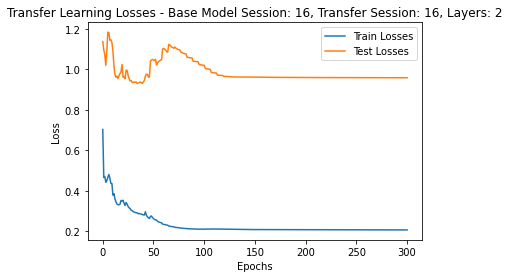

Transfer Learning: Swapping 1 layer, Base Model Parameters Frozen
Base Model Session: 16
Transfer Session: 17
Num Conv Layers: 2, Total Parameters: 21321
Epoch: 000, LR: 0.010000, Train Loss: 33.5112352, Test Loss: 13.6842163
Epoch: 050, LR: 0.007000, Train Loss: 2.8307573, Test Loss: 5.3095320
Epoch: 100, LR: 0.004900, Train Loss: 2.1919588, Test Loss: 4.0801524
Epoch: 150, LR: 0.004900, Train Loss: 1.9564543, Test Loss: 3.7157915
Epoch: 200, LR: 0.000404, Train Loss: 1.6716587, Test Loss: 3.6537321
Epoch: 250, LR: 0.000023, Train Loss: 1.6053468, Test Loss: 3.6395868
Epoch: 300, LR: 0.000010, Train Loss: 1.6005120, Test Loss: 3.6395002


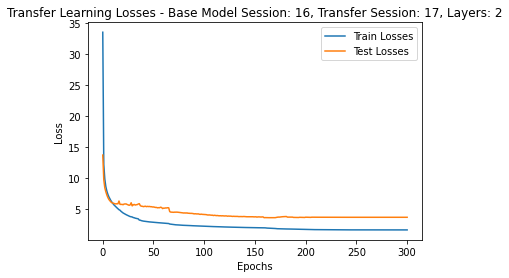

Transfer Learning: Swapping 1 layer, Base Model Parameters Frozen
Base Model Session: 16
Transfer Session: 18
Num Conv Layers: 2, Total Parameters: 21629
Epoch: 000, LR: 0.010000, Train Loss: 24.0907454, Test Loss: 14.0537748
Epoch: 050, LR: 0.010000, Train Loss: 3.7212869, Test Loss: 4.7675412
Epoch: 100, LR: 0.002401, Train Loss: 2.6178240, Test Loss: 4.6814575
Epoch: 150, LR: 0.000097, Train Loss: 2.3775711, Test Loss: 4.4390570
Epoch: 200, LR: 0.000010, Train Loss: 2.3562786, Test Loss: 4.4274055
Epoch: 250, LR: 0.000010, Train Loss: 2.3543746, Test Loss: 4.4262339
Epoch: 300, LR: 0.000010, Train Loss: 2.3526261, Test Loss: 4.4249022


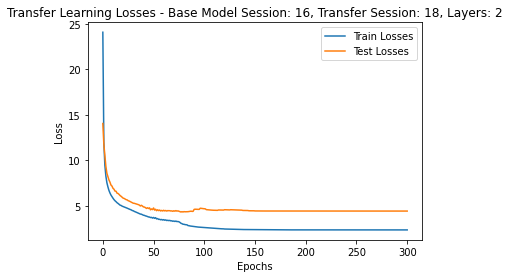

Transfer Learning: Swapping 1 layer, Base Model Parameters Frozen
Base Model Session: 16
Transfer Session: 19
Num Conv Layers: 2, Total Parameters: 20320
Epoch: 000, LR: 0.010000, Train Loss: 25.4105778, Test Loss: 13.1327244
Epoch: 050, LR: 0.010000, Train Loss: 3.4851848, Test Loss: 5.7919068
Epoch: 100, LR: 0.003430, Train Loss: 2.3746235, Test Loss: 5.3725775
Epoch: 150, LR: 0.001176, Train Loss: 2.0486374, Test Loss: 5.1171350
Epoch: 200, LR: 0.000138, Train Loss: 1.9029111, Test Loss: 5.0743873
Epoch: 250, LR: 0.000011, Train Loss: 1.8735669, Test Loss: 5.0533225
Epoch: 300, LR: 0.000010, Train Loss: 1.8710577, Test Loss: 5.0543516


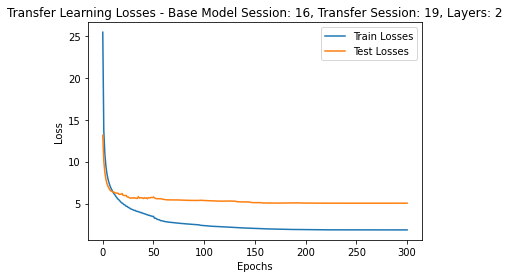

Transfer Learning: Swapping 1 layer, Base Model Parameters Frozen
Base Model Session: 17
Transfer Session: 16
Num Conv Layers: 2, Total Parameters: 22322
Epoch: 000, LR: 0.010000, Train Loss: 11.2549644, Test Loss: 5.2377019
Epoch: 050, LR: 0.003430, Train Loss: 0.7648336, Test Loss: 2.3043067
Epoch: 100, LR: 0.003430, Train Loss: 0.6032457, Test Loss: 2.0042952
Epoch: 150, LR: 0.000824, Train Loss: 0.5114204, Test Loss: 2.0476481
Epoch: 200, LR: 0.000404, Train Loss: 0.4784225, Test Loss: 1.8934791
Epoch: 250, LR: 0.000404, Train Loss: 0.4610529, Test Loss: 1.8729859
Epoch: 300, LR: 0.000404, Train Loss: 0.4451602, Test Loss: 1.8453685


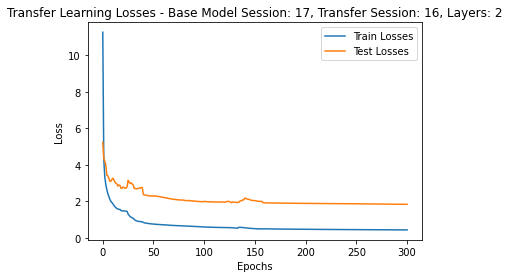

Transfer Learning: Swapping 1 layer, Base Model Parameters Frozen
Base Model Session: 17
Transfer Session: 17
Num Conv Layers: 2, Total Parameters: 21321
Epoch: 000, LR: 0.010000, Train Loss: 1.8468198, Test Loss: 3.8537289
Epoch: 050, LR: 0.002401, Train Loss: 0.8971274, Test Loss: 2.1025851
Epoch: 100, LR: 0.000138, Train Loss: 0.8096477, Test Loss: 2.1166892
Epoch: 150, LR: 0.000010, Train Loss: 0.7993380, Test Loss: 2.1167304
Epoch: 200, LR: 0.000010, Train Loss: 0.7985716, Test Loss: 2.1177890
Epoch: 250, LR: 0.000010, Train Loss: 0.7979094, Test Loss: 2.1187011
Epoch: 300, LR: 0.000010, Train Loss: 0.7973017, Test Loss: 2.1196440


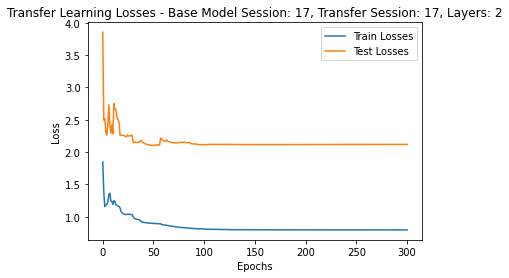

Transfer Learning: Swapping 1 layer, Base Model Parameters Frozen
Base Model Session: 17
Transfer Session: 18
Num Conv Layers: 2, Total Parameters: 21629
Epoch: 000, LR: 0.010000, Train Loss: 22.4414460, Test Loss: 11.2730797
Epoch: 050, LR: 0.003430, Train Loss: 3.3808526, Test Loss: 5.9218622
Epoch: 100, LR: 0.000198, Train Loss: 2.8123002, Test Loss: 5.5484817
Epoch: 150, LR: 0.000011, Train Loss: 2.7505325, Test Loss: 5.5470203
Epoch: 200, LR: 0.000010, Train Loss: 2.7466749, Test Loss: 5.5490737
Epoch: 250, LR: 0.000010, Train Loss: 2.7433472, Test Loss: 5.5500233
Epoch: 300, LR: 0.000010, Train Loss: 2.7401393, Test Loss: 5.5508886


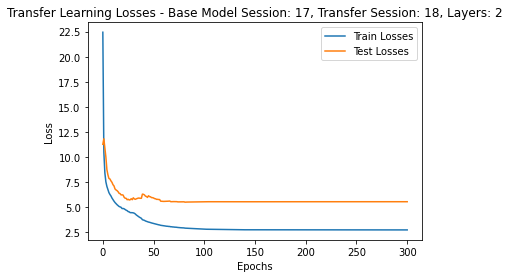

Transfer Learning: Swapping 1 layer, Base Model Parameters Frozen
Base Model Session: 17
Transfer Session: 19
Num Conv Layers: 2, Total Parameters: 20320
Epoch: 000, LR: 0.010000, Train Loss: 60.8305662, Test Loss: 24.3236038
Epoch: 050, LR: 0.007000, Train Loss: 4.4995597, Test Loss: 6.1070250
Epoch: 100, LR: 0.000404, Train Loss: 3.2256518, Test Loss: 7.1110817
Epoch: 150, LR: 0.000016, Train Loss: 3.1196841, Test Loss: 7.1082051
Epoch: 200, LR: 0.000010, Train Loss: 3.1148038, Test Loss: 7.1092915
Epoch: 250, LR: 0.000010, Train Loss: 3.1114994, Test Loss: 7.1102419
Epoch: 300, LR: 0.000010, Train Loss: 3.1082837, Test Loss: 7.1105600


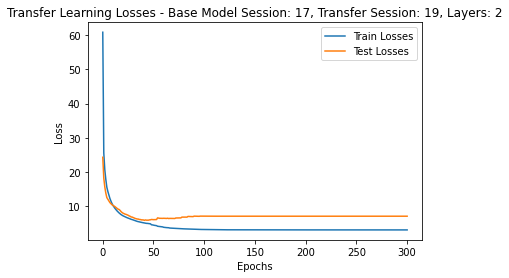

Transfer Learning: Swapping 1 layer, Base Model Parameters Frozen
Base Model Session: 18
Transfer Session: 16
Num Conv Layers: 2, Total Parameters: 22322
Epoch: 000, LR: 0.010000, Train Loss: 15.5084189, Test Loss: 4.3331844
Epoch: 050, LR: 0.007000, Train Loss: 0.9831151, Test Loss: 2.2133953
Epoch: 100, LR: 0.001681, Train Loss: 0.6779340, Test Loss: 2.0996537
Epoch: 150, LR: 0.001176, Train Loss: 0.5709228, Test Loss: 1.7892559
Epoch: 200, LR: 0.000576, Train Loss: 0.5302362, Test Loss: 1.6192819
Epoch: 250, LR: 0.000068, Train Loss: 0.4985469, Test Loss: 1.6028580
Epoch: 300, LR: 0.000010, Train Loss: 0.4906983, Test Loss: 1.6253054


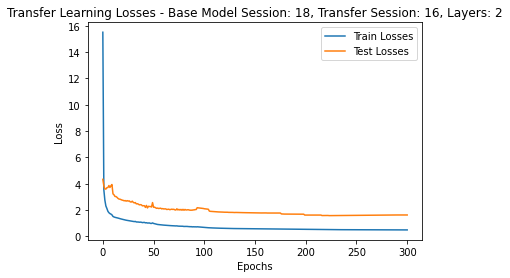

Transfer Learning: Swapping 1 layer, Base Model Parameters Frozen
Base Model Session: 18
Transfer Session: 17
Num Conv Layers: 2, Total Parameters: 21321
Epoch: 000, LR: 0.010000, Train Loss: 27.3381310, Test Loss: 13.5602436
Epoch: 050, LR: 0.010000, Train Loss: 3.2447285, Test Loss: 4.2306017
Epoch: 100, LR: 0.001681, Train Loss: 2.0793604, Test Loss: 3.7242622
Epoch: 150, LR: 0.001176, Train Loss: 1.8843339, Test Loss: 3.6451094
Epoch: 200, LR: 0.000824, Train Loss: 1.7720906, Test Loss: 3.5877166
Epoch: 250, LR: 0.000576, Train Loss: 1.6928637, Test Loss: 3.5041119
Epoch: 300, LR: 0.000282, Train Loss: 1.6309804, Test Loss: 3.4268082


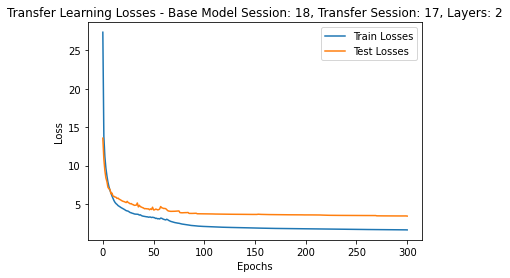

Transfer Learning: Swapping 1 layer, Base Model Parameters Frozen
Base Model Session: 18
Transfer Session: 18
Num Conv Layers: 2, Total Parameters: 21629
Epoch: 000, LR: 0.010000, Train Loss: 2.0179004, Test Loss: 4.0935732
Epoch: 050, LR: 0.000576, Train Loss: 1.3216548, Test Loss: 4.2350631
Epoch: 100, LR: 0.000033, Train Loss: 1.2546042, Test Loss: 4.2484464
Epoch: 150, LR: 0.000010, Train Loss: 1.2502705, Test Loss: 4.2506805
Epoch: 200, LR: 0.000010, Train Loss: 1.2487907, Test Loss: 4.2523518
Epoch: 250, LR: 0.000010, Train Loss: 1.2473683, Test Loss: 4.2539914
Epoch: 300, LR: 0.000010, Train Loss: 1.2459896, Test Loss: 4.2551952


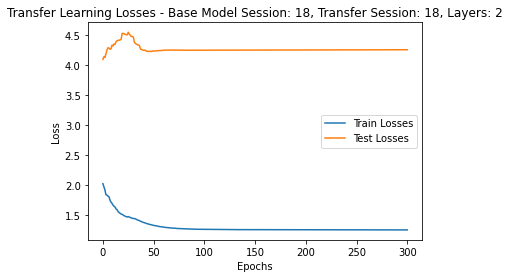

Transfer Learning: Swapping 1 layer, Base Model Parameters Frozen
Base Model Session: 18
Transfer Session: 19
Num Conv Layers: 2, Total Parameters: 20320
Epoch: 000, LR: 0.010000, Train Loss: 29.4127397, Test Loss: 21.0238198
Epoch: 050, LR: 0.010000, Train Loss: 3.7879439, Test Loss: 6.2198106
Epoch: 100, LR: 0.001681, Train Loss: 2.4143914, Test Loss: 5.9955772
Epoch: 150, LR: 0.000068, Train Loss: 2.1527223, Test Loss: 6.1171873
Epoch: 200, LR: 0.000010, Train Loss: 2.1359187, Test Loss: 6.0878082
Epoch: 250, LR: 0.000010, Train Loss: 2.1333443, Test Loss: 6.0842545
Epoch: 300, LR: 0.000010, Train Loss: 2.1308871, Test Loss: 6.0805693


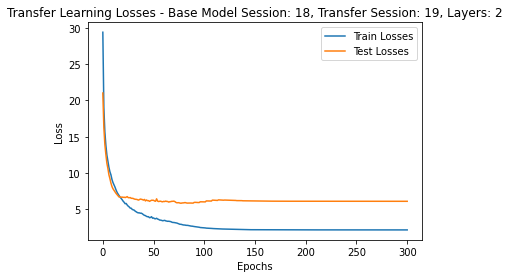

Transfer Learning: Swapping 1 layer, Base Model Parameters Frozen
Base Model Session: 19
Transfer Session: 16
Num Conv Layers: 2, Total Parameters: 22322
Epoch: 000, LR: 0.010000, Train Loss: 8.8677308, Test Loss: 4.8738375
Epoch: 050, LR: 0.002401, Train Loss: 0.6822581, Test Loss: 1.3212517
Epoch: 100, LR: 0.000576, Train Loss: 0.5142706, Test Loss: 1.2695572
Epoch: 150, LR: 0.000576, Train Loss: 0.4693187, Test Loss: 1.2172025
Epoch: 200, LR: 0.000404, Train Loss: 0.4407238, Test Loss: 1.1985949
Epoch: 250, LR: 0.000097, Train Loss: 0.4191756, Test Loss: 1.1982994
Epoch: 300, LR: 0.000010, Train Loss: 0.4133596, Test Loss: 1.2012749


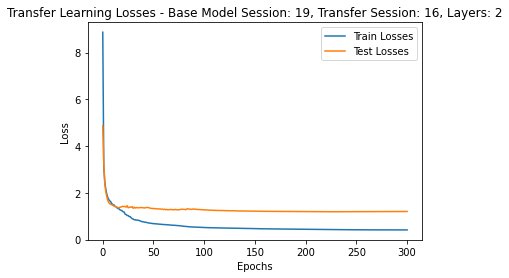

Transfer Learning: Swapping 1 layer, Base Model Parameters Frozen
Base Model Session: 19
Transfer Session: 17
Num Conv Layers: 2, Total Parameters: 21321
Epoch: 000, LR: 0.010000, Train Loss: 30.5991608, Test Loss: 11.3581252
Epoch: 050, LR: 0.010000, Train Loss: 3.5159493, Test Loss: 5.4640202
Epoch: 100, LR: 0.000576, Train Loss: 2.4360418, Test Loss: 4.9474930
Epoch: 150, LR: 0.000097, Train Loss: 2.3062801, Test Loss: 4.8695649
Epoch: 200, LR: 0.000010, Train Loss: 2.2819534, Test Loss: 4.8800653
Epoch: 250, LR: 0.000010, Train Loss: 2.2791415, Test Loss: 4.8821880
Epoch: 300, LR: 0.000010, Train Loss: 2.2764650, Test Loss: 4.8841892


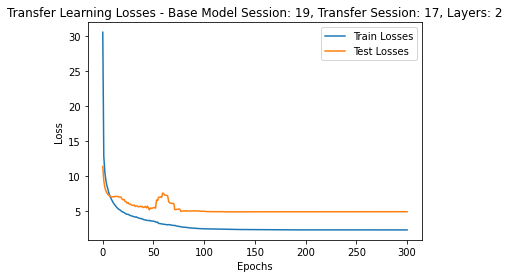

Transfer Learning: Swapping 1 layer, Base Model Parameters Frozen
Base Model Session: 19
Transfer Session: 18
Num Conv Layers: 2, Total Parameters: 21629
Epoch: 000, LR: 0.010000, Train Loss: 19.9742064, Test Loss: 12.6386506
Epoch: 050, LR: 0.003430, Train Loss: 2.9591686, Test Loss: 5.5924740
Epoch: 100, LR: 0.001176, Train Loss: 2.4674887, Test Loss: 5.1521676
Epoch: 150, LR: 0.000097, Train Loss: 2.2706460, Test Loss: 5.1357498
Epoch: 200, LR: 0.000010, Train Loss: 2.2488453, Test Loss: 5.1287441
Epoch: 250, LR: 0.000010, Train Loss: 2.2462066, Test Loss: 5.1252529
Epoch: 300, LR: 0.000010, Train Loss: 2.2437262, Test Loss: 5.1221602


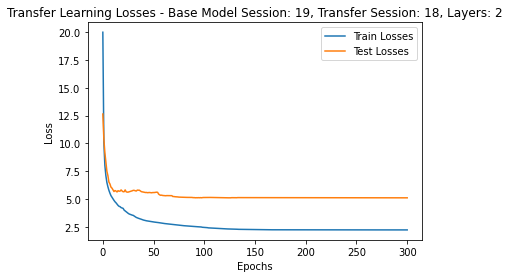

Transfer Learning: Swapping 1 layer, Base Model Parameters Frozen
Base Model Session: 19
Transfer Session: 19
Num Conv Layers: 2, Total Parameters: 20320
Epoch: 000, LR: 0.010000, Train Loss: 1.2341886, Test Loss: 3.1088703
Epoch: 050, LR: 0.000824, Train Loss: 0.7129480, Test Loss: 3.0670032
Epoch: 100, LR: 0.000047, Train Loss: 0.6683383, Test Loss: 3.0938216
Epoch: 150, LR: 0.000010, Train Loss: 0.6637978, Test Loss: 3.0883321
Epoch: 200, LR: 0.000010, Train Loss: 0.6628687, Test Loss: 3.0899980
Epoch: 250, LR: 0.000010, Train Loss: 0.6620746, Test Loss: 3.0913450
Epoch: 300, LR: 0.000010, Train Loss: 0.6613587, Test Loss: 3.0922948


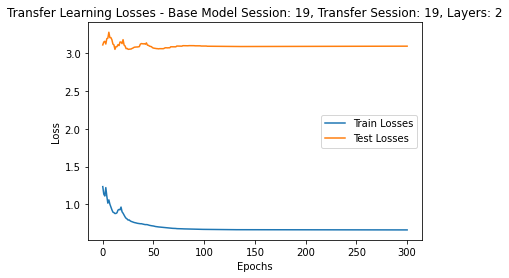

In [ ]:
all_instance_data_tf_learning_aftertrain_freeze = []
for s1 in range(4):
    #make copy of model with 3 convolutional layers
    model_s1 = copy.deepcopy(loaded_models_array[s1][0])
    
    #freeze parameters from base model
    for param in model_s1.parameters():
        param.requires_grad = False

    model_instance_data = []
    for s2, (train_dataset, test_dataset) in enumerate(zip(train_dataset_list, test_dataset_list)):
        #make another copy of model with 3 convolutional layers
        model_s2 = copy.deepcopy(loaded_models_array[s2][0])
        
        #put last layer of model_s2 into model_s1
        model_s1.net[-1] = model_s2.net[-1]
        model_s1.net[-3] = model_s2.net[-3]

        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(model_s1.parameters(), lr=0.01)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.7, patience=5, min_lr=0.00001)   
        total_params = sum(p.numel() for p in model_s1.parameters())

        print('Transfer Learning: Swapping 1 layer, Base Model Parameters Frozen')
        print('Base Model Session: {}'.format(s1+16))
        print('Transfer Session: {}'.format(s2+16))
        print('Num Conv Layers: {}, Total Parameters: {}'\
            .format(model_s1.num_conv_layers, total_params))
        
        train_losses = []
        val_losses = []
        test_losses = []
        for epoch in range(301):
            # torch.cuda.empty_cache()
            lr = scheduler.optimizer.param_groups[0]['lr']
            train_loss = train(train_dataset, model_s1, optimizer, criterion)
            test_loss = test(test_dataset, model_s1, optimizer, criterion)
            scheduler.step(test_loss)
            if epoch % 50==0:
                print('Epoch: {:03d}, LR: {:7f}, Train Loss: {:.7f}, Test Loss: {:.7f}'\
                      .format(epoch, lr, train_loss, test_loss))

            train_losses.append(train_loss)
            test_losses.append(test_loss)

        # get the losses for each sample after training is done
        instance_data = [get_instance_losses(train_dataset, model_s1),\
                                get_instance_losses(test_dataset, model_s1)]
        model_instance_data.append(instance_data)

        plt.plot(train_losses)
        plt.plot(test_losses)
        plt.title('Transfer Learning Losses - Base Model Session: {}, Transfer Session: {}, Layers: {}'.format(s1+16, s2+16, model_s1.num_conv_layers))
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(['Train Losses', 'Test Losses'])
        plt.show()

        # save model
        directory = '/content/drive/My Drive/Miller_Lab/FIU/Temporal_CNN/TransferLearning/2convlayers_1convlayerswap/'
        model_name = 'basesession{}_transfersession{}_3convlayers.pth'.format(s1+16, s2+16)
        torch.save(model_s1.state_dict(), directory+model_name)

    all_instance_data_tf_learning_aftertrain_freeze.append(model_instance_data)

In [ ]:
for s1 in range(4):
    table = np.zeros((4,2))
    s2_labels = []
    for s2 in range(4):
        s2_labels.append('Session {}'.format(s2+16))
        instance_data = all_instance_data_tf_learning_aftertrain_freeze[s1][s2]

        for k in range(2): #plot train, val, test data
            instance_targets = instance_data[k][2]
            instance_preds = instance_data[k][3]
            session_num = instance_data[k][6]

            r2 = sklearn.metrics.r2_score(instance_targets,instance_preds,multioutput='variance_weighted')
            table[s2,k] += r2

    print('Session {} Variance Weighted R^2 Scores (transfer 1 layer)'.format(s1+16))
    df = pd.DataFrame(table, columns = ['Train','Test'], index = s2_labels)
    display(df)

Session 16 Variance Weighted R^2 Scores (transfer 1 layer)


,Train,Test
Session 16,0.991392,0.954187
Session 17,0.960230,0.907653
Session 18,0.927449,0.829985
Session 19,0.952211,0.871926


Session 17 Variance Weighted R^2 Scores (transfer 1 layer)


,Train,Test
Session 16,0.975090,0.916650
Session 17,0.981426,0.917464
Session 18,0.915572,0.784762
Session 19,0.924161,0.813708


Session 18 Variance Weighted R^2 Scores (transfer 1 layer)


,Train,Test
Session 16,0.979134,0.926850
Session 17,0.960589,0.883230
Session 18,0.961415,0.845154
Session 19,0.948035,0.842939


Session 19 Variance Weighted R^2 Scores (transfer 1 layer)


,Train,Test
Session 16,0.982723,0.941939
Session 17,0.942243,0.860420
Session 18,0.930530,0.808271
Session 19,0.983863,0.925425


### Swap 1 convolutional layer + readout layer for model with 3 convolutional layers

Transfer Learning: Swapping 1 layer, Base Model Parameters Frozen
Base Model Session: 16
Transfer Session: 16
Num Conv Layers: 3, Total Parameters: 84338
Epoch: 000, LR: 0.010000, Train Loss: 0.4290123, Test Loss: 1.1364534
Epoch: 050, LR: 0.000824, Train Loss: 0.1397792, Test Loss: 1.2771488
Epoch: 100, LR: 0.000047, Train Loss: 0.1257954, Test Loss: 1.2142922
Epoch: 150, LR: 0.000010, Train Loss: 0.1246376, Test Loss: 1.2228971
Epoch: 200, LR: 0.000010, Train Loss: 0.1243760, Test Loss: 1.2208614
Epoch: 250, LR: 0.000010, Train Loss: 0.1241514, Test Loss: 1.2200147
Epoch: 300, LR: 0.000010, Train Loss: 0.1239441, Test Loss: 1.2194955


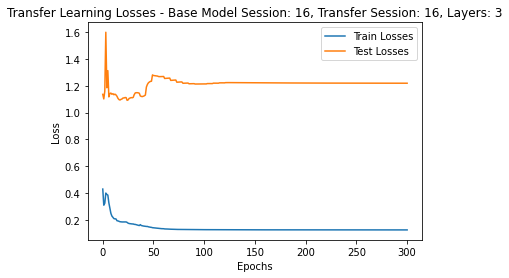

Transfer Learning: Swapping 1 layer, Base Model Parameters Frozen
Base Model Session: 16
Transfer Session: 17
Num Conv Layers: 3, Total Parameters: 82349
Epoch: 000, LR: 0.010000, Train Loss: 24.4914492, Test Loss: 12.2670724
Epoch: 050, LR: 0.003430, Train Loss: 7.0395702, Test Loss: 7.8902775
Epoch: 100, LR: 0.000824, Train Loss: 5.5755644, Test Loss: 7.4310364
Epoch: 150, LR: 0.000198, Train Loss: 5.2042570, Test Loss: 7.0735228
Epoch: 200, LR: 0.000097, Train Loss: 5.0602153, Test Loss: 6.9923992
Epoch: 250, LR: 0.000016, Train Loss: 4.9929783, Test Loss: 6.9680486
Epoch: 300, LR: 0.000010, Train Loss: 4.9835017, Test Loss: 6.9679038


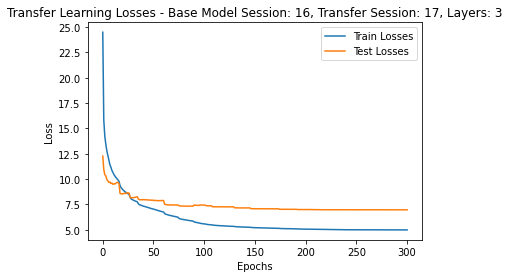

Transfer Learning: Swapping 1 layer, Base Model Parameters Frozen
Base Model Session: 16
Transfer Session: 18
Num Conv Layers: 3, Total Parameters: 82961
Epoch: 000, LR: 0.010000, Train Loss: 21.7485765, Test Loss: 14.3782119
Epoch: 050, LR: 0.003430, Train Loss: 4.7189028, Test Loss: 8.6316680
Epoch: 100, LR: 0.000576, Train Loss: 3.5440064, Test Loss: 8.8232478
Epoch: 150, LR: 0.000033, Train Loss: 3.3606386, Test Loss: 8.4994768
Epoch: 200, LR: 0.000010, Train Loss: 3.3448805, Test Loss: 8.5019668
Epoch: 250, LR: 0.000010, Train Loss: 3.3398926, Test Loss: 8.5037237
Epoch: 300, LR: 0.000010, Train Loss: 3.3351627, Test Loss: 8.5052257


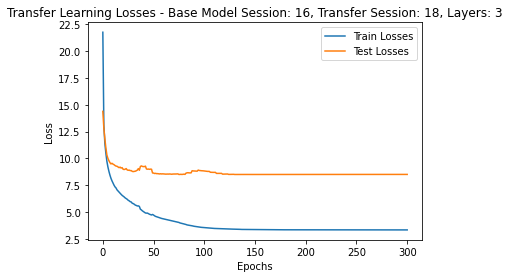

Transfer Learning: Swapping 1 layer, Base Model Parameters Frozen
Base Model Session: 16
Transfer Session: 19
Num Conv Layers: 3, Total Parameters: 80360
Epoch: 000, LR: 0.010000, Train Loss: 27.7408718, Test Loss: 15.5575231
Epoch: 050, LR: 0.003430, Train Loss: 6.1858234, Test Loss: 10.6385498
Epoch: 100, LR: 0.000198, Train Loss: 4.5727954, Test Loss: 10.9270521
Epoch: 150, LR: 0.000011, Train Loss: 4.4823124, Test Loss: 10.8941296
Epoch: 200, LR: 0.000010, Train Loss: 4.4756525, Test Loss: 10.8845359
Epoch: 250, LR: 0.000010, Train Loss: 4.4694670, Test Loss: 10.8739488
Epoch: 300, LR: 0.000010, Train Loss: 4.4633666, Test Loss: 10.8631069


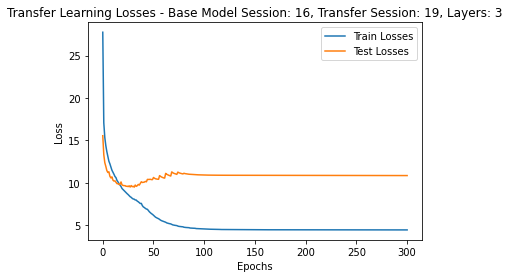

Transfer Learning: Swapping 1 layer, Base Model Parameters Frozen
Base Model Session: 17
Transfer Session: 16
Num Conv Layers: 3, Total Parameters: 84338
Epoch: 000, LR: 0.010000, Train Loss: 15.9408179, Test Loss: 4.7225496
Epoch: 050, LR: 0.004900, Train Loss: 1.1502865, Test Loss: 3.3366651
Epoch: 100, LR: 0.001176, Train Loss: 0.8142638, Test Loss: 2.6547463
Epoch: 150, LR: 0.000282, Train Loss: 0.7220944, Test Loss: 2.4080732
Epoch: 200, LR: 0.000023, Train Loss: 0.6862465, Test Loss: 2.4559875
Epoch: 250, LR: 0.000010, Train Loss: 0.6831093, Test Loss: 2.4633816
Epoch: 300, LR: 0.000010, Train Loss: 0.6818638, Test Loss: 2.4628386


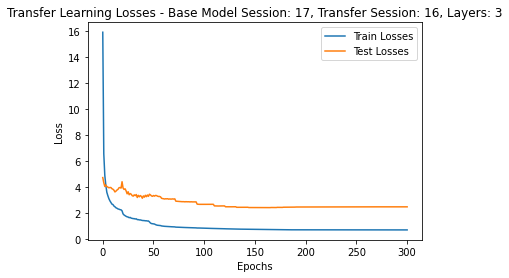

Transfer Learning: Swapping 1 layer, Base Model Parameters Frozen
Base Model Session: 17
Transfer Session: 17
Num Conv Layers: 3, Total Parameters: 82349
Epoch: 000, LR: 0.010000, Train Loss: 1.6888429, Test Loss: 3.4816272
Epoch: 050, LR: 0.001176, Train Loss: 0.8220468, Test Loss: 2.7312079
Epoch: 100, LR: 0.000138, Train Loss: 0.7527503, Test Loss: 2.6133063
Epoch: 150, LR: 0.000010, Train Loss: 0.7392901, Test Loss: 2.6155587
Epoch: 200, LR: 0.000010, Train Loss: 0.7381667, Test Loss: 2.6156782
Epoch: 250, LR: 0.000010, Train Loss: 0.7371627, Test Loss: 2.6157087
Epoch: 300, LR: 0.000010, Train Loss: 0.7362235, Test Loss: 2.6159048


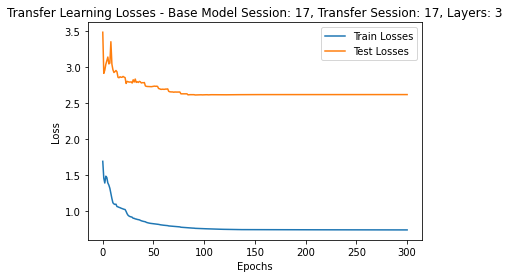

Transfer Learning: Swapping 1 layer, Base Model Parameters Frozen
Base Model Session: 17
Transfer Session: 18
Num Conv Layers: 3, Total Parameters: 82961
Epoch: 000, LR: 0.010000, Train Loss: 18.2316452, Test Loss: 15.0805789
Epoch: 050, LR: 0.003430, Train Loss: 5.6086807, Test Loss: 10.1011674
Epoch: 100, LR: 0.000404, Train Loss: 4.8540783, Test Loss: 9.9824298
Epoch: 150, LR: 0.000016, Train Loss: 4.6989208, Test Loss: 9.9660706
Epoch: 200, LR: 0.000010, Train Loss: 4.6908746, Test Loss: 9.9736839
Epoch: 250, LR: 0.000010, Train Loss: 4.6863366, Test Loss: 9.9767173
Epoch: 300, LR: 0.000010, Train Loss: 4.6819522, Test Loss: 9.9791905


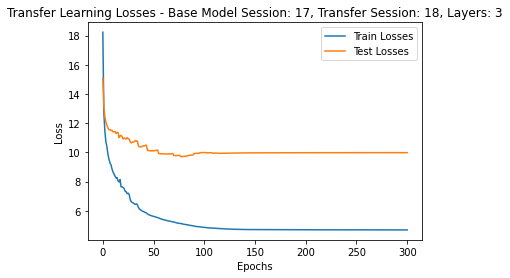

Transfer Learning: Swapping 1 layer, Base Model Parameters Frozen
Base Model Session: 17
Transfer Session: 19
Num Conv Layers: 3, Total Parameters: 80360
Epoch: 000, LR: 0.010000, Train Loss: 34.8114363, Test Loss: 22.1058658
Epoch: 050, LR: 0.003430, Train Loss: 8.2733742, Test Loss: 16.3618578
Epoch: 100, LR: 0.000198, Train Loss: 6.8203305, Test Loss: 14.4776433
Epoch: 150, LR: 0.000010, Train Loss: 6.6837157, Test Loss: 14.2758113
Epoch: 200, LR: 0.000010, Train Loss: 6.6740337, Test Loss: 14.2663456
Epoch: 250, LR: 0.000010, Train Loss: 6.6648884, Test Loss: 14.2671527
Epoch: 300, LR: 0.000010, Train Loss: 6.6560367, Test Loss: 14.2723932


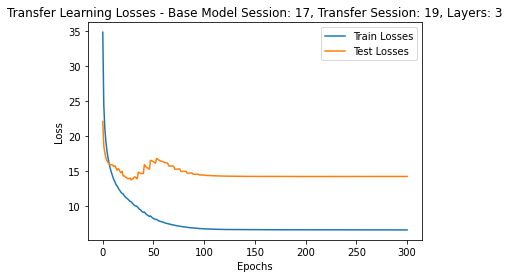

Transfer Learning: Swapping 1 layer, Base Model Parameters Frozen
Base Model Session: 18
Transfer Session: 16
Num Conv Layers: 3, Total Parameters: 84338
Epoch: 000, LR: 0.010000, Train Loss: 8.2589329, Test Loss: 6.8638281
Epoch: 050, LR: 0.003430, Train Loss: 1.0453469, Test Loss: 4.8313164
Epoch: 100, LR: 0.000198, Train Loss: 0.7913990, Test Loss: 4.8858473
Epoch: 150, LR: 0.000011, Train Loss: 0.7405846, Test Loss: 4.8330590
Epoch: 200, LR: 0.000010, Train Loss: 0.7371445, Test Loss: 4.8296350
Epoch: 250, LR: 0.000010, Train Loss: 0.7343037, Test Loss: 4.8287482
Epoch: 300, LR: 0.000010, Train Loss: 0.7316547, Test Loss: 4.8294588


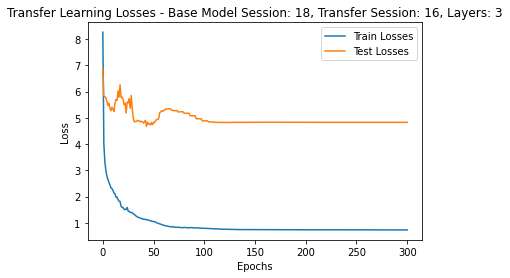

Transfer Learning: Swapping 1 layer, Base Model Parameters Frozen
Base Model Session: 18
Transfer Session: 17
Num Conv Layers: 3, Total Parameters: 82349
Epoch: 000, LR: 0.010000, Train Loss: 27.4055007, Test Loss: 15.0527409
Epoch: 050, LR: 0.000824, Train Loss: 4.5463328, Test Loss: 12.4057680
Epoch: 100, LR: 0.000047, Train Loss: 4.0298515, Test Loss: 12.5411866
Epoch: 150, LR: 0.000010, Train Loss: 3.9955141, Test Loss: 12.5666688
Epoch: 200, LR: 0.000010, Train Loss: 3.9860787, Test Loss: 12.5810149
Epoch: 250, LR: 0.000010, Train Loss: 3.9769238, Test Loss: 12.6000664
Epoch: 300, LR: 0.000010, Train Loss: 3.9679291, Test Loss: 12.6211047


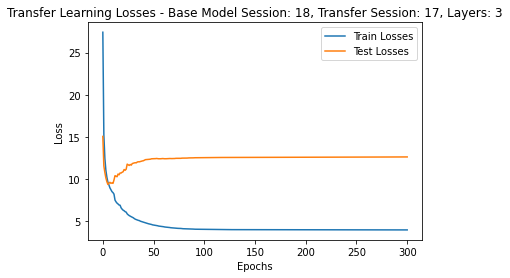

Transfer Learning: Swapping 1 layer, Base Model Parameters Frozen
Base Model Session: 18
Transfer Session: 18
Num Conv Layers: 3, Total Parameters: 82961
Epoch: 000, LR: 0.010000, Train Loss: 1.4351379, Test Loss: 5.1316713
Epoch: 050, LR: 0.000576, Train Loss: 0.8252007, Test Loss: 5.1240130
Epoch: 100, LR: 0.000033, Train Loss: 0.7528414, Test Loss: 5.1667697
Epoch: 150, LR: 0.000010, Train Loss: 0.7486888, Test Loss: 5.1687995
Epoch: 200, LR: 0.000010, Train Loss: 0.7475075, Test Loss: 5.1705215
Epoch: 250, LR: 0.000010, Train Loss: 0.7463758, Test Loss: 5.1720205
Epoch: 300, LR: 0.000010, Train Loss: 0.7452766, Test Loss: 5.1735783


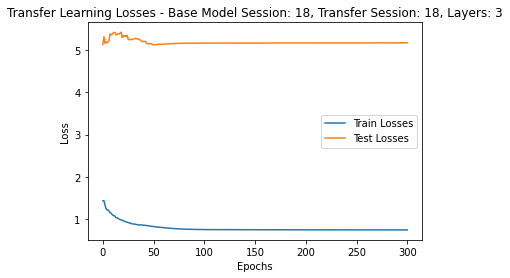

Transfer Learning: Swapping 1 layer, Base Model Parameters Frozen
Base Model Session: 18
Transfer Session: 19
Num Conv Layers: 3, Total Parameters: 80360
Epoch: 000, LR: 0.010000, Train Loss: 31.9865426, Test Loss: 20.7634316
Epoch: 050, LR: 0.002401, Train Loss: 4.4801578, Test Loss: 14.4582049
Epoch: 100, LR: 0.000097, Train Loss: 3.7875627, Test Loss: 14.9336600
Epoch: 150, LR: 0.000010, Train Loss: 3.6985577, Test Loss: 14.9353011
Epoch: 200, LR: 0.000010, Train Loss: 3.6861310, Test Loss: 14.9476963
Epoch: 250, LR: 0.000010, Train Loss: 3.6744403, Test Loss: 14.9587653
Epoch: 300, LR: 0.000010, Train Loss: 3.6632675, Test Loss: 14.9689411


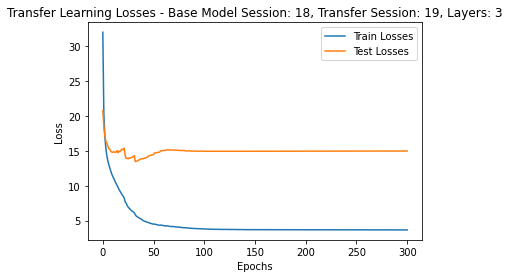

Transfer Learning: Swapping 1 layer, Base Model Parameters Frozen
Base Model Session: 19
Transfer Session: 16
Num Conv Layers: 3, Total Parameters: 84338
Epoch: 000, LR: 0.010000, Train Loss: 12.9417395, Test Loss: 6.4897861
Epoch: 050, LR: 0.010000, Train Loss: 1.2154625, Test Loss: 1.8935342
Epoch: 100, LR: 0.000576, Train Loss: 0.6119102, Test Loss: 1.8497519
Epoch: 150, LR: 0.000097, Train Loss: 0.5500010, Test Loss: 1.6962240
Epoch: 200, LR: 0.000023, Train Loss: 0.5366863, Test Loss: 1.6855139
Epoch: 250, LR: 0.000010, Train Loss: 0.5335751, Test Loss: 1.6840750
Epoch: 300, LR: 0.000010, Train Loss: 0.5323421, Test Loss: 1.6840387


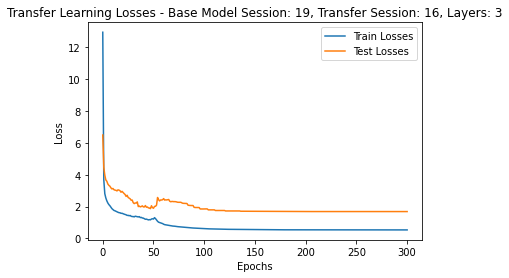

Transfer Learning: Swapping 1 layer, Base Model Parameters Frozen
Base Model Session: 19
Transfer Session: 17
Num Conv Layers: 3, Total Parameters: 82349
Epoch: 000, LR: 0.010000, Train Loss: 32.8376068, Test Loss: 15.7149449
Epoch: 050, LR: 0.001681, Train Loss: 4.4957038, Test Loss: 7.1126113
Epoch: 100, LR: 0.000576, Train Loss: 3.6813437, Test Loss: 6.4410149
Epoch: 150, LR: 0.000033, Train Loss: 3.4335438, Test Loss: 6.5559359
Epoch: 200, LR: 0.000010, Train Loss: 3.4071470, Test Loss: 6.5797413
Epoch: 250, LR: 0.000010, Train Loss: 3.3994799, Test Loss: 6.5777933
Epoch: 300, LR: 0.000010, Train Loss: 3.3922912, Test Loss: 6.5742150


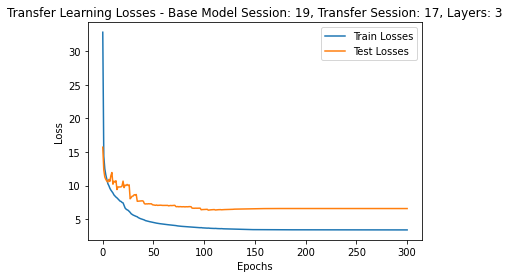

Transfer Learning: Swapping 1 layer, Base Model Parameters Frozen
Base Model Session: 19
Transfer Session: 18
Num Conv Layers: 3, Total Parameters: 82961
Epoch: 000, LR: 0.010000, Train Loss: 18.7143953, Test Loss: 12.8685635
Epoch: 050, LR: 0.002401, Train Loss: 3.6968366, Test Loss: 8.3066650
Epoch: 100, LR: 0.000138, Train Loss: 2.9871920, Test Loss: 8.5811678
Epoch: 150, LR: 0.000010, Train Loss: 2.9295110, Test Loss: 8.6282752
Epoch: 200, LR: 0.000010, Train Loss: 2.9236103, Test Loss: 8.6338543
Epoch: 250, LR: 0.000010, Train Loss: 2.9179133, Test Loss: 8.6392829
Epoch: 300, LR: 0.000010, Train Loss: 2.9123498, Test Loss: 8.6447772


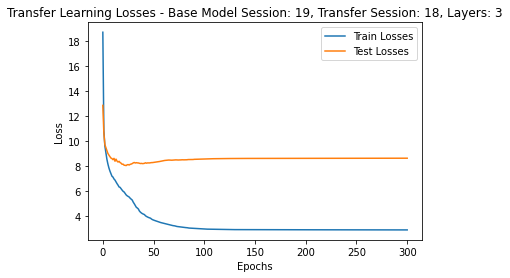

Transfer Learning: Swapping 1 layer, Base Model Parameters Frozen
Base Model Session: 19
Transfer Session: 19
Num Conv Layers: 3, Total Parameters: 80360
Epoch: 000, LR: 0.010000, Train Loss: 1.3376198, Test Loss: 3.5964592
Epoch: 050, LR: 0.001176, Train Loss: 0.6214086, Test Loss: 3.6241932
Epoch: 100, LR: 0.000068, Train Loss: 0.5504266, Test Loss: 3.5754637
Epoch: 150, LR: 0.000010, Train Loss: 0.5440742, Test Loss: 3.5725207
Epoch: 200, LR: 0.000010, Train Loss: 0.5430473, Test Loss: 3.5736590
Epoch: 250, LR: 0.000010, Train Loss: 0.5420918, Test Loss: 3.5744122
Epoch: 300, LR: 0.000010, Train Loss: 0.5411728, Test Loss: 3.5751214


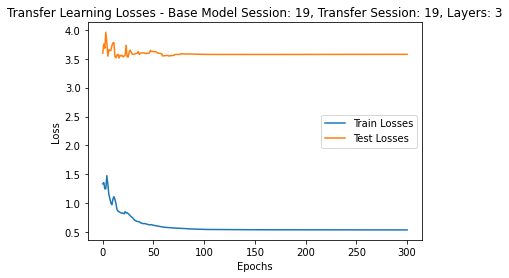

In [ ]:
all_instance_data_tf_learning_aftertrain_freeze = []
for s1 in range(4):
    #make copy of model with 3 convolutional layers
    model_s1 = copy.deepcopy(loaded_models_array[s1][1])
    
    #freeze parameters from base model
    for param in model_s1.parameters():
        param.requires_grad = False

    model_instance_data = []
    for s2, (train_dataset, test_dataset) in enumerate(zip(train_dataset_list, test_dataset_list)):
        #make another copy of model with 3 convolutional layers
        model_s2 = copy.deepcopy(loaded_models_array[s2][1])
        
        #put last layer of model_s2 into model_s1
        model_s1.net[-1] = model_s2.net[-1]
        model_s1.net[-3] = model_s2.net[-3]

        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(model_s1.parameters(), lr=0.01)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.7, patience=5, min_lr=0.00001)   
        total_params = sum(p.numel() for p in model_s1.parameters())

        print('Transfer Learning: Swapping 1 layer, Base Model Parameters Frozen')
        print('Base Model Session: {}'.format(s1+16))
        print('Transfer Session: {}'.format(s2+16))
        print('Num Conv Layers: {}, Total Parameters: {}'\
            .format(model_s1.num_conv_layers, total_params))
        
        train_losses = []
        val_losses = []
        test_losses = []
        for epoch in range(301):
            # torch.cuda.empty_cache()
            lr = scheduler.optimizer.param_groups[0]['lr']
            train_loss = train(train_dataset, model_s1, optimizer, criterion)
            test_loss = test(test_dataset, model_s1, optimizer, criterion)
            scheduler.step(test_loss)
            if epoch % 50==0:
                print('Epoch: {:03d}, LR: {:7f}, Train Loss: {:.7f}, Test Loss: {:.7f}'\
                      .format(epoch, lr, train_loss, test_loss))

            train_losses.append(train_loss)
            test_losses.append(test_loss)

        # get the losses for each sample after training is done
        instance_data = [get_instance_losses(train_dataset, model_s1),\
                                get_instance_losses(test_dataset, model_s1)]
        model_instance_data.append(instance_data)

        plt.plot(train_losses)
        plt.plot(test_losses)
        plt.title('Transfer Learning Losses - Base Model Session: {}, Transfer Session: {}, Layers: {}'.format(s1+16, s2+16, model_s1.num_conv_layers))
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(['Train Losses', 'Test Losses'])
        plt.show()

        # save model
        directory = '/content/drive/My Drive/Miller_Lab/FIU/Temporal_CNN/TransferLearning/1convlayerswap/'
        model_name = 'basesession{}_transfersession{}_3convlayers.pth'.format(s1+16, s2+16)
        torch.save(model_s1.state_dict(), directory+model_name)

    all_instance_data_tf_learning_aftertrain_freeze.append(model_instance_data)

In [ ]:
for s1 in range(4):
    table = np.zeros((4,2))
    s2_labels = []
    for s2 in range(4):
        s2_labels.append('Session {}'.format(s2+16))
        instance_data = all_instance_data_tf_learning_aftertrain_freeze[s1][s2]

        for k in range(2): #plot train, val, test data
            instance_targets = instance_data[k][2]
            instance_preds = instance_data[k][3]
            session_num = instance_data[k][6]

            r2 = sklearn.metrics.r2_score(instance_targets,instance_preds,multioutput='variance_weighted')
            table[s2,k] += r2

    print('Session {} Variance Weighted R^2 Scores (transfer 1 layer)'.format(s1+16))
    df = pd.DataFrame(table, columns = ['Train','Test'], index = s2_labels)
    display(df)

Session 16 Variance Weighted R^2 Scores (transfer 1 layer)


,Train,Test
Session 16,0.994521,0.944395
Session 17,0.870555,0.785757
Session 18,0.891903,0.658490
Session 19,0.890170,0.711730


Session 17 Variance Weighted R^2 Scores (transfer 1 layer)


,Train,Test
Session 16,0.964864,0.886677
Session 17,0.981612,0.884368
Session 18,0.857366,0.614298
Session 19,0.827384,0.629885


Session 18 Variance Weighted R^2 Scores (transfer 1 layer)


,Train,Test
Session 16,0.951701,0.772205
Session 17,0.898747,0.695631
Session 18,0.974225,0.809235
Session 19,0.908957,0.628658


Session 19 Variance Weighted R^2 Scores (transfer 1 layer)


,Train,Test
Session 16,0.977146,0.925461
Session 17,0.910153,0.806304
Session 18,0.894758,0.675438
Session 19,0.985772,0.907548
